# Машинное обучение в криптовалюте

## Описание проекта

С помощью данных, взятых с криптовалютного рынка Binance, о пяти случайных и не слишком популярных монетах, попробуем создать модель, которая будет предсказывать рост или падение цены за последние пару часов на определенную монету. Это поможет определить и создать правила для точек входа и выхода из различных позиций

## Описание данных

Данные были взяты с сайта Binance из раздела Kline/Candlestick Data. Я решил взять 5 не очень популярных валют за последние 24 часа. Считывание данных будем производить с помощью трех библиотек requests, json и pandas для создания датафрейма. Введем параметры для вывода данных с сайта, так как архив очень большой. Зададим интервал считывания свечей interval=1m, их кол-во с помощью limit=1440 штук - это 24 часа. И последний параметр startTime - это время, с которого мы будем брать данные с биржи, чтобы все валюты считались в одно время.

## Установка и импорт библиотек

In [1]:
!pip install pandas
!pip install requests
!pip install json


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

## Используемые функции

In [3]:
# Вывод различной информации о таблице
def analiz(df):
    df.info()
    print()
    display(df.describe())
    print()
    print('Кол-во пропусков в таблице')
    display(df.isna().sum())
    print()
    print('Кол-во дубликатов в таблице')
    display(df.duplicated().sum())
    print()
    print('Проверка на неявные дубликаты')
    print()
    print()
    print()


# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df



# Функция для построения гистограмм и ящиков с усами для каждого признака
def numbers_plot(df, param_hue):
    sns.set(font_scale=1.2)
    cols = coins[0].columns
    fig, axs = plt.subplots(len(cols), 2, figsize=(11, 14))
    
    for i in range(len(cols)):
        column = cols[i]
        sns.histplot(data = df, x = column, hue=param_hue, ax = axs[i, 0], common_norm=False, legend=False)
        axs[i, 0].set_title(column)
        
        sns.boxplot(x = df[column], ax = axs[i, 1])
        axs[i, 1].set_title(column)
    
    plt.tight_layout()
    plt.show()




# функция создания указанного кол-ва новых признаков. Это лаги и скользящее среднее
def make_features(data, max_lag, rolling_mean_size, columns):
    for column in columns:
        for lag in range(1, max_lag + 1):
            new_column_name = f'lag_{column}_{lag}' 
            data[new_column_name] = data[column].shift(lag)
        data[f'rolling_mean_{column}'] = data[column].shift().rolling(rolling_mean_size).mean()


# функция созданич указанного кол-ва новых признаков, которые будут еще дальше. Это лаги и скользящее среднее
def make_features_app(data, max_lag, rolling_mean_size, columns): 
    for column in columns:
        for lag in range(1, max_lag + 1):
            new_column_name = f'lag_{column}_{lag + 9}'  # добавляем 9 для задержки в 10
            data[new_column_name] = data[column].shift(lag + 9)  # добавляем 35 для задержки в 10
        data[f'rolling_mean_{column}'] = data[column].shift(9).rolling(rolling_mean_size).mean()  # добавляем 35 для задержки в 10




# обучение модели, получение предсказаний и графика
def prognoz(data, model, param_grid):
    columns = ['open', 'high', 'low', 'volume', 'number_of_trades', 'btc']
    TEST_SIZE = 0.1
    RANDOM_STATE = 42
    params = [1, 3]
    for i in params:
        for j in params:
            make_features(data, i, j, columns) # создаем временные признаки
            X = data.drop(['open', 'high', 'low', 'volume', 'number_of_trades', 'btc'], axis=1) # удаляем спойлеры
            y = data['open']
            q = len(X)
            X = X.dropna() # удаляем первые строки с пропусками из-за создания временных признаков
            w = len(X)
            y = y[q - w:]
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
            scaler = StandardScaler() # масштабирование
            X_train_scaler = scaler.fit_transform(X_train)
            X_test_scaler = scaler.transform(X_test)
            
            model = model
            gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
            gs.fit(X_train_scaler, y_train)
            predictions = gs.predict(X_test_scaler)
            best_rmse_1 = (-gs.best_score_)**0.5
            mae = mean_absolute_error(y_test, predictions)
            print(f'max_lag = {i}')
            print(f'rolling_mean_size = {j}')
            print(best_rmse_1)
            print(f'MAE: {mae}')
            print()
            
    predic = pd.DataFrame(predictions, columns=['предсказания'])
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, predic, label='Предсказания', color='blue') # строим предсказания
    plt.plot(y_test.index, y_test, label='Реальность', color='green') # строим тестовые целевые значения
    plt.legend()
    plt.show()




# предсказание входа и выхода для интервала свечей в 30 мин
def rule_1(data):
    param_grid = {}
    n = int(0.005 * len(data)) # длина тестовой выборки
    columns = ['open', 'high', 'low', 'volume', 'number_of_trades', 'btc']
    RANDOM_STATE = 42
    c = 0 # счетчик для определения момента входа и выхода
    back = [] # массив, хранящий точки выхода
    enter = [] # массив, хранящий точки входа
    predic = [] # хранит значения каждого предикта, сделанного в реальном времени
    time_b = [] # массив, хранящий время точки выхода
    time_e = [] # массив, хранящий время точки входа
    for k in range(n): # данный цикл помогает нам делать прогноз в реальном времени
        TEST_SIZE = 0.005 - k * 0.001 # с помощью этого действия каждую итерацию цикла у нас уменьшается тестовая выборка на 1 значение слева
        data_k = data.copy() # на всякий случай создаем копию, чтобы массив не изменился
        make_features(data_k, 3, 3, columns) # создаем временные признаки
        X = data_k.drop(['open', 'high', 'low', 'volume', 'number_of_trades', 'btc'], axis=1) # удаляем спойлеры
        y = data_k['open']
        q = len(X)
        X = X.dropna() # удаляем первые строки с пропусками из-за создания временных признаков
        w = len(X)
        y = y[q - w:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        if k == 0:
            y_test_c = y_test.copy() # данная копия поможет нам обратиться к изначально полному массиву для графиков, так как потом он будет уменьшаться
        proc = y_test_c.sum() / len(y_test_c) # вычисляем среднее, чтобы потом по нему посчитать процент изменения цены
        scaler = StandardScaler()
        X_train_scaler = scaler.fit_transform(X_train)
        X_test_scaler = scaler.transform(X_test)
        
        model = LinearRegression()
        gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        gs.fit(X_train_scaler, y_train)
        predictions = gs.predict(X_test_scaler)
        predic.append(predictions[0]) # берем только первый элемент предсказаний, чтобы можно было работать в реальном времени
        if k > 0: # это начало создания правила

            if c == 0: 
                if ((predic[k]) > (predic[k-1])): # сравниваем предсказанное значение с прошлым, чтобы понять поднялась ли цена
                    enter.append(y_test_c.iloc[k-1]) # если цена поднялась по предсказанию, то добавляем точку, как вход
                    time_e.append(k-1) # запоминаем время для отображения на графике
                    c = 1 # при с == 1 у нас не будет определен еще один вход пока не найдется выход
            elif c == 1:
                if ((predic[k]) < (predic[k-1])): # сравниваем предсказанное значение с прошлым, чтобы понять упала ли цена
                    back.append(y_test_c.iloc[k-1]) # если цена поднялась по предсказанию, то добавляем точку, как выход
                    time_b.append(k-1)
                    c = 0

    predict = pd.DataFrame(predic, columns=['предсказания'])
    time = [0, 30, 60, 90, 120]
    for i in range(len(time_e)):
        time_e[i] = time_e[i] * 30 # переводим значения времени под тестовые значения для графика
    for i in range(len(time_b)):
        time_b[i] = time_b[i] * 30
    plt.figure(figsize=(10, 6))
    plt.plot(time, predict, label='Предсказания', color='blue')
    plt.plot(time, y_test_c, label='Реальность', color='green')
    plt.scatter(time_e, enter, s=100, color='green', marker='o', label='Enter')
    plt.scatter(time_b, back, s=100, color='red', marker='o', label='Back')
    plt.legend()
    plt.show()
    if len(back) < len(enter): # если кол-во выходов и входов не совпадает, то мы добавляем для выхода элемент из последнего значения тестовой выборки
        back.append(y_test_c.iloc[-1])
        
    sum = 0 # считаем сумму выручки без комиссии
    for i in range(len(back)):
        sum += back[i] - enter[i]
    print('Выручка: ', sum)
    print('Выручка в процентах: ', sum * 100 / proc, '%')
    print('Кол-во сделок: ', len(enter))

    sum_brok = 0 # считаем сумму выручки с комиссией
    camiss = 0.001 # это 0.1% комиссии брокера
    for i in range(len(back)):
        sum_brok += (back[i]-(camiss*back[i])) - (enter[i]+(camiss*enter[i]))
    print('Чистая прибыль: ', sum_brok)
    print('Чистая прибыль в процентах: ', sum_brok * 100 / proc, '%')
# остальные функции +- похожи на другие, поэтому я не буду делать комментарии


    

# предсказание входа и выхода для интервала свечей в 1 мин
def rule_2(data):
    param_grid = {}
    n = int(0.1 * len(data))
    columns = ['open', 'high', 'low', 'volume', 'number_of_trades', 'btc']
    RANDOM_STATE = 42
    c = 0
    back = []
    enter = []
    predic = []
    time_b = []
    time_e = []
    c_p = 0
    c_m = 0
    for k in range(n):
        TEST_SIZE = 0.1 - k * (0.1 - 143*0.1 / 144)
        data_k = data.copy()
        make_features(data_k, 3, 3, columns) # создаем временные признаки
        X = data_k.drop(['open', 'high', 'low', 'volume', 'number_of_trades', 'btc'], axis=1) # удаляем спойлеры
        y = data_k['open']
        q = len(X)
        X = X.dropna() # удаляем первые строки с пропусками из-за создания временных признаков
        w = len(X)
        y = y[q - w:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        if k == 0:
            y_test_c = y_test.copy()
        proc = y_test_c.sum() / len(y_test_c)
            
        scaler = StandardScaler()
        X_train_scaler = scaler.fit_transform(X_train)
        X_test_scaler = scaler.transform(X_test)
        
        model = LinearRegression()
        gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        gs.fit(X_train_scaler, y_train)
        predictions = gs.predict(X_test_scaler)
        predic.append(predictions[0])
        if k > 5:
            if ((predic[k]) > (predic[k-1])):
                c_p += 1
                if c_p >= 2:
                    c += 4
                    c_p = 0
                c += 1
                if (c > 4) and (len(enter) == len(back)):
                    enter.append(y_test_c.iloc[k-1])
                    time_e.append(k-1)
                    c = 0
                    c_p = 0
                if (c > 1) and (len(enter) > len(back)):
                    c = 0
                    c_p = 0
            if ((predic[k]) < (predic[k-1])):
                c_m += 1
                if c_m == 2:
                    c -= 4
                    c_m = 0
                if (c < -4) and (len(enter) > len(back)):
                    back.append(y_test_c.iloc[k-1])
                    time_b.append(k-1)
                    c = 0
                    c_m = 0
                if (c < -1) and (len(enter) == len(back)):
                    c = 0
                    c_m = 0
                    
    predict = pd.DataFrame(predic, columns=['предсказания'])
    time = np.arange(144)
    plt.figure(figsize=(15, 8))
    plt.plot(time, predict, label='Предсказания', color='blue')
    plt.plot(time, y_test_c, label='Реальность', color='green')
    plt.scatter(time_e, enter, s=100, color='green', marker='o', label='Enter')
    plt.scatter(time_b, back, s=100, color='red', marker='o', label='Back')
    plt.legend()
    plt.show() 
    if len(back) < len(enter):
        back.append(y_test_c.iloc[-1])
    sum = 0
    for i in range(len(back)):
        sum += back[i] - enter[i]
    print('Выручка: ', sum)
    print('Выручка в процентах: ', sum * 100 / proc, '%')
    print('Кол-во сделок: ', len(enter))

    sum_brok = 0
    camiss = 0.001
    for i in range(len(back)):
        sum_brok += (back[i]-(camiss*back[i])) - (enter[i]+(camiss*enter[i]))
    print('Чистая прибыль: ', sum_brok)
    print('Чистая прибыль в процентах: ', sum_brok * 100 / proc, '%')




# функция для общего правила. Сначала делаем предсказание на 30 минут, а потом поминутно пока снова не пройдет 30 мин
def rule(data, data_1):
    param_grid = {}
    n = int(0.1 * len(data_1))
    columns = ['open', 'high', 'low', 'volume', 'number_of_trades', 'btc']
    RANDOM_STATE = 42
    c_rule = 0 # счетчик кол-ва пройденых интервалов в 30 мин
    c = 0
    back = []
    enter = []
    predic = []
    predic_1 = []
    time_b = []
    time_e = []
    c_p = 0 # кол-во подряд идущих повышений в цене
    c_m = 0 # кол-во подряд идущих падений в цене
    k_c = 0 # не даем сделать выход, если не прошло более 5 минут
    pokupka = 0 # флаг: 0 - нельзя взодить и выходить ближайшие 30 мин
    for k in range(n): # циклом перебираем интервалы в 1 минуту, где обучаем две модели. k - минута из будущего
        if k in [10, 40, 70, 100, 130]: # если у нас k равно значению в интервале 30 мин, то мы делаем одно предсказание на 30 мин вперед
            TEST_SIZE = 0.005 - c_rule * 0.001 # динамическая тестовая и трен выборки, чтобы не забегать за спойлерами в будущее
            data_k = data.copy()
            make_features(data_k, 3, 3, columns) # создаем временные признаки
            X = data_k.drop(['open', 'high', 'low', 'volume', 'number_of_trades', 'btc'], axis=1) # удаляем спойлеры
            y = data_k['open']
            q = len(X)
            X = X.dropna() # удаляем первые строки с пропусками из-за создания временных признаков
            w = len(X)
            y = y[q - w:]
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
            if c_rule == 0:
                y_test_c = y_test.copy()
            proc = y_test_c.sum() / len(y_test_c)
            scaler = StandardScaler()
            X_train_scaler = scaler.fit_transform(X_train)
            X_test_scaler = scaler.transform(X_test)
            
            model = LinearRegression()
            gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
            gs.fit(X_train_scaler, y_train)
            predictions = gs.predict(X_test_scaler)
            predic.append(predictions[0])
            if ((predic[c_rule]) > (predic[c_rule-1])):
                pokupka = 1
            if ((predic[c_rule]) <= (predic[c_rule-1])):
                pokupka = 0
            c_rule += 1
           
        TEST_SIZE = 0.1 - k * (0.1 - 143*0.1 / 144)
        data_k_1 = data_1.copy()
        make_features(data_k_1, 3, 3, columns) # создаем временные признаки
        X = data_k_1.drop(['open', 'high', 'low', 'volume', 'number_of_trades', 'btc'], axis=1) # удаляем спойлеры
        y = data_k_1['open']
        q = len(X)
        X = X.dropna() # удаляем первые строки с пропусками из-за создания временных признаков
        w = len(X)
        y = y[q - w:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        if k == 0:
            y_test_c_1 = y_test.copy()
        proc = y_test_c_1.sum() / len(y_test_c_1)
            
        scaler = StandardScaler()
        X_train_scaler = scaler.fit_transform(X_train)
        X_test_scaler = scaler.transform(X_test)
        
        model = LinearRegression()
        gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        gs.fit(X_train_scaler, y_train)
        predictions = gs.predict(X_test_scaler)
        predic_1.append(predictions[0])
        if (k > 5) and (pokupka == 1): # можем начинать проводить сделки после первых 5 минут
            k_c += 1
            if ((predic_1[k]) > (predic_1[k-1])):
                c_p += 1
                if c_p >= 3: # гарантированный вход при 2 подряд повышениях цен
                    c += 6
                    c_p = 0
                if c_p >= 2: # практически гарантированный вход при 2 подряд повышениях цен
                    c += 4
                c += 1
                if (c > 4) and (len(enter) == len(back)):
                    enter.append(y_test_c_1.iloc[k-1])
                    time_e.append(k-1)
                    c = 0
                    c_p = 0
                    k_c = 1
                if (c > 1) and (len(enter) > len(back)):
                    c = 0
                    c_p = 0
            if ((predic_1[k]) < (predic_1[k-1])):
                c_m += 1
                if c_m == 3:
                    c -= 6
                    c_m = 0
                if c_m == 2:
                    c -= 4
                if (c < -4) and (len(enter) > len(back)) and (k_c > 5):
                    back.append(y_test_c_1.iloc[k-1])
                    time_b.append(k-1)
                    c = 0
                    c_m = 0
                    k_c = 0
                if (c < -1) and (len(enter) == len(back)):
                    c = 0
                    c_m = 0
        if (pokupka == 0) and (len(enter) > len(back)):
            enter.pop()
            time_e.pop()
            c = 0
            c_p = 0
            k_c = 0
            
    predict = pd.DataFrame(predic_1, columns=['предсказания'])
    time = np.arange(144)
    plt.figure(figsize=(15, 8))
    plt.plot(time, predict, label='Предсказания', color='blue')
    plt.plot(time, y_test_c_1, label='Реальность', color='green')
    plt.scatter(time_e, enter, s=100, color='green', marker='o', label='Enter')
    plt.scatter(time_b, back, s=100, color='red', marker='o', label='Back')
    plt.legend()
    plt.show() 
    if len(back) < len(enter):
        back.append(y_test_c_1.iloc[-1])
    sum = 0
    for i in range(len(back)):
        sum += back[i] - enter[i]
    print('Выручка: ', sum)
    print('Выручка в процентах: ', sum * 100 / proc, '%')
    print('Кол-во сделок: ', len(enter))

    sum_brok = 0
    camiss = 0.001 # это 0.1%
    for i in range(len(back)):
        sum_brok += (back[i]-(camiss*back[i])) - (enter[i]+(camiss*enter[i]))
    print('Чистая прибыль: ', sum_brok)
    print('Чистая прибыль в процентах: ', sum_brok * 100 / proc, '%')

## Загрузка и подготовка данных

Выполним запрос к API биржи Binance по указанному URL, содержащий параметры для запроса данных о свечах (candlestick) с биржи Binance, включая символ валютной пары, интервал времени, лимит свечей и начальное время. Будем считывать каждый датасет в список, чтобы потом его переименовать под нужные нам валюты и посмотрим, что из этого получится.

In [4]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
    'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

symbols = ['ILVUSDT', 'TRBUSDT', 'MANAUSDT', 'HOOKUSDT', 'WLDUSDT']

dfs = []

for symbol in symbols:
    params = {
        'symbol': symbol,
        'interval': '1m',  
        'limit': 1440,
        'startTime': 1723096800000, 
    }
    url = 'https://fapi.binance.com/fapi/v1/klines'
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data, columns=columns)
        dfs.append(df)  
    else:
        print(f'Ошибка {response.status_code}: {response.text}')

In [5]:
ILV_USDT = dfs[0]
print('Таблица ILV_USDT:')
display(ILV_USDT.head())
print(ILV_USDT.shape)
print()

TRB_USDT = dfs[1]
print('Таблица TRB_USDT:')
display(TRB_USDT.head())
print(TRB_USDT.shape)
print()

MANA_USDT = dfs[2]
print('Таблица MANA_USDT:')
display(MANA_USDT.head())
print(MANA_USDT.shape)
print()

HOOK_USDT = dfs[3]
print('Таблица HOOK_USDT:')
display(HOOK_USDT.head())
print(HOOK_USDT.shape)
print()

WLD_USDT = dfs[4]
print('Таблица WLD_USDT:')
display(WLD_USDT.head())
print(WLD_USDT.shape)
print()

Таблица ILV_USDT:


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1723096800000,41.84000,41.91000,41.82000,41.90000,131.9,1723096859999,5522.267000,71,74.9,3136.665000,0
1,1723096860000,41.89000,41.89000,41.84000,41.84000,57.2,1723096919999,2394.118000,49,12.9,540.063000,0
2,1723096920000,41.83000,41.85000,41.71000,41.71000,54.2,1723096979999,2263.745000,48,10.3,430.111000,0
3,1723096980000,41.73000,41.75000,41.68000,41.75000,102.3,1723097039999,4267.488000,65,83.3,3475.135000,0
4,1723097040000,41.75000,41.82000,41.74000,41.80000,62.9,1723097099999,2628.163000,54,47.3,1976.443000,0


(1440, 12)

Таблица TRB_USDT:


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1723096800000,56.458,56.479,56.280,56.341,1496.7,1723096859999,84350.0209,603,655.0,36900.3578,0
1,1723096860000,56.339,56.348,56.173,56.177,1369.2,1723096919999,77004.5117,524,228.7,12861.9968,0
2,1723096920000,56.183,56.204,56.034,56.103,1812.8,1723096979999,101721.9139,552,1028.5,57709.9677,0
3,1723096980000,56.108,56.204,56.005,56.199,2189.5,1723097039999,122780.1871,637,898.8,50412.7701,0
4,1723097040000,56.200,56.280,56.198,56.226,1299.3,1723097099999,73066.2452,409,446.6,25120.9683,0


(1440, 12)

Таблица MANA_USDT:


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1723096800000,0.2648,0.2654,0.2648,0.2653,77184,1723096859999,20466.7963,109,59409,15753.3150,0
1,1723096860000,0.2654,0.2654,0.2650,0.2650,36605,1723096919999,9707.5978,83,14314,3797.6881,0
2,1723096920000,0.2649,0.2649,0.2641,0.2642,64024,1723096979999,16940.3366,88,12684,3352.9145,0
3,1723096980000,0.2641,0.2642,0.2639,0.2642,57648,1723097039999,15223.1597,90,33218,8772.7731,0
4,1723097040000,0.2643,0.2647,0.2643,0.2646,43041,1723097099999,11380.8011,65,28015,7407.9937,0


(1440, 12)

Таблица HOOK_USDT:


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1723096800000,0.354500,0.355000,0.354300,0.354800,15682.9,1723096859999,5560.3461400,69,11176.4,3962.7714500,0
1,1723096860000,0.354900,0.354900,0.353700,0.353700,16264.2,1723096919999,5759.8761100,57,867.1,307.1422500,0
2,1723096920000,0.353700,0.353700,0.352300,0.352600,26928.5,1723096979999,9498.4721300,88,932.2,328.9275700,0
3,1723096980000,0.352500,0.352500,0.351600,0.352200,92522.7,1723097039999,32576.0316400,152,17378.5,6118.9747800,0
4,1723097040000,0.352300,0.352700,0.352000,0.352400,49775.5,1723097099999,17535.1813700,106,23051.8,8120.5246900,0


(1440, 12)

Таблица WLD_USDT:


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1723096800000,1.6436000,1.6469000,1.6436000,1.6460000,101080,1723096859999,166336.6147000,924,76628,126098.3216000,0
1,1723096860000,1.6460000,1.6467000,1.6416000,1.6417000,118373,1723096919999,194642.0347000,876,64820,106596.6137000,0
2,1723096920000,1.6420000,1.6422000,1.6384000,1.6387000,183429,1723096979999,300847.1255000,1047,127834,209682.3783000,0
3,1723096980000,1.6386000,1.6390000,1.6335000,1.6371000,203132,1723097039999,332318.1986000,1330,78823,128979.2866000,0
4,1723097040000,1.6371000,1.6392000,1.6345000,1.6389000,189983,1723097099999,310992.9721000,1032,137290,224743.1162000,0


(1440, 12)



Получилось 5 таблиц, как я и планировал. Их размеры одинаковые 1000 на 12. Разберем каждый признак по порядку:
* open_time. Время открытия свечи в формате метки времени Unix (в миллисекундах)
* open. Цена открытия свечи
* high. Наивысшая цена за период свечи
* low. Наименьшая цена за период свечи
* close. Цена закрытия свечи
* volume. Объем торгов в базовой валюте
* close_time. Время закрытия свечи в формате метки времени Unix (в миллисекундах)
* quote_asset_volume. Объем торгов в котируемой валюте
* number_of_trades кол-во совершенных сделок за период свечи
* taker_buy_base_asset_volume. Объем базовой валюты, купленный принимающей стороной сделки
* taker_buy_quote_asset_volume. Объем котируемой валюты, купленный принимающей стороной сделки
* ignore. Игнорируемые данные для свечи. Они нам не пригодятся, поэтому их стоит удалить

Можем посмотреть на различную общую информацию о наших таблицах. В этом нам поможет функция analiz.

In [6]:
ILV_USDT = ILV_USDT.drop('ignore', axis = 1)
TRB_USDT = TRB_USDT.drop('ignore', axis = 1)
MANA_USDT = MANA_USDT.drop('ignore', axis = 1)
HOOK_USDT = HOOK_USDT.drop('ignore', axis = 1)
WLD_USDT = WLD_USDT.drop('ignore', axis = 1)
coins = [ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT]

In [7]:
for coin in coins:
    analiz(coin)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open_time                     1440 non-null   int64 
 1   open                          1440 non-null   object
 2   high                          1440 non-null   object
 3   low                           1440 non-null   object
 4   close                         1440 non-null   object
 5   volume                        1440 non-null   object
 6   close_time                    1440 non-null   int64 
 7   quote_asset_volume            1440 non-null   object
 8   number_of_trades              1440 non-null   int64 
 9   taker_buy_base_asset_volume   1440 non-null   object
 10  taker_buy_quote_asset_volume  1440 non-null   object
dtypes: int64(3), object(8)
memory usage: 123.9+ KB



,open_time,close_time,number_of_trades
count,1.440000e+03,1.440000e+03,1440.000000
mean,1.723140e+12,1.723140e+12,52.284722
std,2.495019e+07,2.495019e+07,82.937216
min,1.723097e+12,1.723097e+12,0.000000
25%,1.723118e+12,1.723118e+12,19.000000
50%,1.723140e+12,1.723140e+12,32.000000
75%,1.723162e+12,1.723162e+12,54.000000
max,1.723183e+12,1.723183e+12,1575.000000



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open_time                     1440 non-null   int64 
 1   open                          1440 non-null   object
 2   high                          1440 non-null   object
 3   low                           1440 non-null   object
 4   close                         1440 non-null   object
 5   volume                        1440 non-null   object
 6   close_time                    1440 non-null   int64 
 7   quote_asset_volume            1440 non-null   object
 8   number_of_trades              1440 non-null   int64 
 9   taker_buy_base_asset_volume   1440 non-null   object
 10  taker_buy_quote_asset_volume  1440 non-null   object
dtypes: int64(3), object(8)
memory usage: 123.9+ KB



,open_time,close_time,number_of_trades
count,1.440000e+03,1.440000e+03,1440.000000
mean,1.723140e+12,1.723140e+12,524.992361
std,2.495019e+07,2.495019e+07,462.796968
min,1.723097e+12,1.723097e+12,64.000000
25%,1.723118e+12,1.723118e+12,269.750000
50%,1.723140e+12,1.723140e+12,402.500000
75%,1.723162e+12,1.723162e+12,627.000000
max,1.723183e+12,1.723183e+12,6141.000000



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open_time                     1440 non-null   int64 
 1   open                          1440 non-null   object
 2   high                          1440 non-null   object
 3   low                           1440 non-null   object
 4   close                         1440 non-null   object
 5   volume                        1440 non-null   object
 6   close_time                    1440 non-null   int64 
 7   quote_asset_volume            1440 non-null   object
 8   number_of_trades              1440 non-null   int64 
 9   taker_buy_base_asset_volume   1440 non-null   object
 10  taker_buy_quote_asset_volume  1440 non-null   object
dtypes: int64(3), object(8)
memory usage: 123.9+ KB



,open_time,close_time,number_of_trades
count,1.440000e+03,1.440000e+03,1440.000000
mean,1.723140e+12,1.723140e+12,62.721528
std,2.495019e+07,2.495019e+07,57.132287
min,1.723097e+12,1.723097e+12,2.000000
25%,1.723118e+12,1.723118e+12,30.000000
50%,1.723140e+12,1.723140e+12,46.500000
75%,1.723162e+12,1.723162e+12,73.250000
max,1.723183e+12,1.723183e+12,592.000000



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open_time                     1440 non-null   int64 
 1   open                          1440 non-null   object
 2   high                          1440 non-null   object
 3   low                           1440 non-null   object
 4   close                         1440 non-null   object
 5   volume                        1440 non-null   object
 6   close_time                    1440 non-null   int64 
 7   quote_asset_volume            1440 non-null   object
 8   number_of_trades              1440 non-null   int64 
 9   taker_buy_base_asset_volume   1440 non-null   object
 10  taker_buy_quote_asset_volume  1440 non-null   object
dtypes: int64(3), object(8)
memory usage: 123.9+ KB



,open_time,close_time,number_of_trades
count,1.440000e+03,1.440000e+03,1440.000000
mean,1.723140e+12,1.723140e+12,46.276389
std,2.495019e+07,2.495019e+07,49.072934
min,1.723097e+12,1.723097e+12,2.000000
25%,1.723118e+12,1.723118e+12,19.000000
50%,1.723140e+12,1.723140e+12,32.000000
75%,1.723162e+12,1.723162e+12,54.000000
max,1.723183e+12,1.723183e+12,566.000000



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open_time                     1440 non-null   int64 
 1   open                          1440 non-null   object
 2   high                          1440 non-null   object
 3   low                           1440 non-null   object
 4   close                         1440 non-null   object
 5   volume                        1440 non-null   object
 6   close_time                    1440 non-null   int64 
 7   quote_asset_volume            1440 non-null   object
 8   number_of_trades              1440 non-null   int64 
 9   taker_buy_base_asset_volume   1440 non-null   object
 10  taker_buy_quote_asset_volume  1440 non-null   object
dtypes: int64(3), object(8)
memory usage: 123.9+ KB



,open_time,close_time,number_of_trades
count,1.440000e+03,1.440000e+03,1440.000000
mean,1.723140e+12,1.723140e+12,839.663889
std,2.495019e+07,2.495019e+07,699.542578
min,1.723097e+12,1.723097e+12,94.000000
25%,1.723118e+12,1.723118e+12,395.750000
50%,1.723140e+12,1.723140e+12,613.500000
75%,1.723162e+12,1.723162e+12,1026.250000
max,1.723183e+12,1.723183e+12,5614.000000



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты





Сразу же можно заметить у многих дробных чисел тип object, который лучше поменять на float, так как мы не можем произвести даже элементарный анализ. Сделаем это ниже

In [8]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
    'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
for coin in coins:
    for column in columns:
        coin[column] = pd.to_numeric(coin[column], errors='coerce')
    print(coin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     1440 non-null   int64  
 1   open                          1440 non-null   float64
 2   high                          1440 non-null   float64
 3   low                           1440 non-null   float64
 4   close                         1440 non-null   float64
 5   volume                        1440 non-null   float64
 6   close_time                    1440 non-null   int64  
 7   quote_asset_volume            1440 non-null   float64
 8   number_of_trades              1440 non-null   int64  
 9   taker_buy_base_asset_volume   1440 non-null   float64
 10  taker_buy_quote_asset_volume  1440 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 123.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 

In [9]:
for coin in coins:
    analiz(coin)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     1440 non-null   int64  
 1   open                          1440 non-null   float64
 2   high                          1440 non-null   float64
 3   low                           1440 non-null   float64
 4   close                         1440 non-null   float64
 5   volume                        1440 non-null   float64
 6   close_time                    1440 non-null   int64  
 7   quote_asset_volume            1440 non-null   float64
 8   number_of_trades              1440 non-null   int64  
 9   taker_buy_base_asset_volume   1440 non-null   float64
 10  taker_buy_quote_asset_volume  1440 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 123.9 KB



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000
mean,1.723140e+12,43.504465,43.541681,43.468861,43.506833,111.087986,1.723140e+12,4923.888540,52.284722,55.530069,2464.008751
std,2.495019e+07,1.476398,1.481821,1.473228,1.478052,281.345271,2.495019e+07,12800.465101,82.937216,159.125968,7249.186645
min,1.723097e+12,41.330000,41.350000,41.300000,41.340000,0.000000,1.723097e+12,0.000000,0.000000,0.000000,0.000000
25%,1.723118e+12,41.930000,41.950000,41.900000,41.930000,18.200000,1.723118e+12,796.083000,19.000000,6.700000,287.803250
50%,1.723140e+12,43.640000,43.670000,43.620000,43.650000,37.500000,1.723140e+12,1631.624000,32.000000,16.950000,729.197500
75%,1.723162e+12,45.130000,45.160000,45.090000,45.120000,97.500000,1.723162e+12,4249.668000,54.000000,45.650000,2012.495250
max,1.723183e+12,46.450000,46.490000,46.380000,46.450000,4867.600000,1.723183e+12,224701.798000,1575.000000,3067.300000,140691.212000



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     1440 non-null   int64  
 1   open                          1440 non-null   float64
 2   high                          1440 non-null   float64
 3   low                           1440 non-null   float64
 4   close                         1440 non-null   float64
 5   volume                        1440 non-null   float64
 6   close_time                    1440 non-null   int64  
 7   quote_asset_volume            1440 non-null   float64
 8   number_of_trades              1440 non-null   int64  
 9   taker_buy_base_asset_volume   1440 non-null   float64
 10  taker_buy_quote_asset_volume  1440 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 123.9 KB



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1.440000e+03,1440.000000,1440.000000,1.440000e+03
mean,1.723140e+12,58.139422,58.200058,58.078448,58.141006,1378.620139,1.723140e+12,7.982024e+04,524.992361,677.030764,3.920758e+04
std,2.495019e+07,1.373643,1.371037,1.375972,1.373554,1919.764548,2.495019e+07,1.097323e+05,462.796968,1057.089497,6.072271e+04
min,1.723097e+12,55.181000,55.245000,55.028000,55.178000,56.700000,1.723097e+12,3.336167e+03,64.000000,11.000000,6.561464e+02
25%,1.723118e+12,56.749500,56.811000,56.697000,56.749750,501.975000,1.723118e+12,2.930663e+04,269.750000,227.150000,1.323552e+04
50%,1.723140e+12,58.289500,58.347000,58.224000,58.291000,876.050000,1.723140e+12,5.090570e+04,402.500000,421.650000,2.450203e+04
75%,1.723162e+12,59.274750,59.342750,59.234000,59.276250,1583.700000,1.723162e+12,9.080428e+04,627.000000,758.300000,4.370804e+04
max,1.723183e+12,61.028000,61.066000,60.877000,61.027000,32302.500000,1.723183e+12,1.844040e+06,6141.000000,23471.300000,1.337832e+06



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     1440 non-null   int64  
 1   open                          1440 non-null   float64
 2   high                          1440 non-null   float64
 3   low                           1440 non-null   float64
 4   close                         1440 non-null   float64
 5   volume                        1440 non-null   int64  
 6   close_time                    1440 non-null   int64  
 7   quote_asset_volume            1440 non-null   float64
 8   number_of_trades              1440 non-null   int64  
 9   taker_buy_base_asset_volume   1440 non-null   int64  
 10  taker_buy_quote_asset_volume  1440 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 123.9 KB



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000
mean,1.723140e+12,0.270471,0.270638,0.270294,0.270472,43944.358333,1.723140e+12,11898.587999,62.721528,22524.162500,6098.738068
std,2.495019e+07,0.005111,0.005116,0.005105,0.005110,61857.289934,2.495019e+07,16744.153111,57.132287,35352.489822,9574.995408
min,1.723097e+12,0.261800,0.262000,0.261500,0.261800,238.000000,1.723097e+12,64.457500,2.000000,0.000000,0.000000
25%,1.723118e+12,0.265600,0.265700,0.265400,0.265600,11228.250000,1.723118e+12,3027.458300,30.000000,4086.750000,1112.623400
50%,1.723140e+12,0.270900,0.271000,0.270800,0.270900,23836.500000,1.723140e+12,6445.333750,46.500000,11037.500000,2995.291600
75%,1.723162e+12,0.275325,0.275500,0.275100,0.275325,51156.000000,1.723162e+12,13732.371025,73.250000,26464.250000,7127.582200
max,1.723183e+12,0.280000,0.280300,0.279800,0.280100,707670.000000,1.723183e+12,188640.063000,592.000000,461784.000000,123722.242100



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     1440 non-null   int64  
 1   open                          1440 non-null   float64
 2   high                          1440 non-null   float64
 3   low                           1440 non-null   float64
 4   close                         1440 non-null   float64
 5   volume                        1440 non-null   float64
 6   close_time                    1440 non-null   int64  
 7   quote_asset_volume            1440 non-null   float64
 8   number_of_trades              1440 non-null   int64  
 9   taker_buy_base_asset_volume   1440 non-null   float64
 10  taker_buy_quote_asset_volume  1440 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 123.9 KB



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000
mean,1.723140e+12,0.359825,0.360090,0.359541,0.359817,12945.949861,1.723140e+12,4670.634893,46.276389,6336.528194,2287.557523
std,2.495019e+07,0.006744,0.006766,0.006738,0.006745,22681.510088,2.495019e+07,8195.910004,49.072934,13193.137735,4786.275248
min,1.723097e+12,0.347400,0.348200,0.347200,0.347300,14.500000,1.723097e+12,5.260600,2.000000,0.000000,0.000000
25%,1.723118e+12,0.353800,0.354000,0.353500,0.353800,2699.200000,1.723118e+12,970.366885,19.000000,830.875000,299.646025
50%,1.723140e+12,0.361250,0.361500,0.361000,0.361300,6001.100000,1.723140e+12,2163.357565,32.000000,2517.050000,902.578265
75%,1.723162e+12,0.363900,0.364125,0.363700,0.363900,13849.525000,1.723162e+12,4998.139285,54.000000,6869.225000,2489.776760
max,1.723183e+12,0.374900,0.375200,0.374000,0.374800,337231.400000,1.723183e+12,118179.163350,566.000000,214128.000000,78178.586270



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     1440 non-null   int64  
 1   open                          1440 non-null   float64
 2   high                          1440 non-null   float64
 3   low                           1440 non-null   float64
 4   close                         1440 non-null   float64
 5   volume                        1440 non-null   int64  
 6   close_time                    1440 non-null   int64  
 7   quote_asset_volume            1440 non-null   float64
 8   number_of_trades              1440 non-null   int64  
 9   taker_buy_base_asset_volume   1440 non-null   int64  
 10  taker_buy_quote_asset_volume  1440 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 123.9 KB



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.440000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03,1.440000e+03,1.440000e+03,1440.000000,1440.000000,1.440000e+03
mean,1.723140e+12,1.706478,1.708499,1.704535,1.706562,1.173605e+05,1.723140e+12,2.038549e+05,839.663889,57951.425000,1.005744e+05
std,2.495019e+07,0.071481,0.071961,0.071008,0.071474,1.348771e+05,2.495019e+07,2.417256e+05,699.542578,71895.497322,1.277943e+05
min,1.723097e+12,1.610800,1.615300,1.606200,1.610600,5.132000e+03,1.723097e+12,8.696334e+03,94.000000,1151.000000,1.950937e+03
25%,1.723118e+12,1.640475,1.642100,1.639200,1.640400,4.290800e+04,1.723118e+12,7.260557e+04,395.750000,19628.500000,3.302569e+04
50%,1.723140e+12,1.692850,1.693900,1.691700,1.692850,7.594000e+04,1.723140e+12,1.313616e+05,613.500000,37155.000000,6.225056e+04
75%,1.723162e+12,1.757425,1.759050,1.756300,1.757425,1.352012e+05,1.723162e+12,2.321182e+05,1026.250000,68488.250000,1.166270e+05
max,1.723183e+12,1.883100,1.890700,1.879300,1.883100,2.027264e+06,1.723183e+12,3.666463e+06,5614.000000,786693.000000,1.420400e+06



Кол-во пропусков в таблице


open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64


Кол-во дубликатов в таблице


0


Проверка на неявные дубликаты





Пропусков и дубликатов не было замечено. Числа получаются достаточно больше, подумаем позже, что с этим можно сделать. Сейчас займемся оптимизацией данных, которая поможет нам ускорить все действия с данными, особенно обучение моделей, что для нас очень важно. В этом нам поможет функция optimize_memory_usage

In [10]:
for coin in coins:
    display(optimize_memory_usage(coin))

Размер использования памяти: до  0.12 Mb - после  0.07 Mb (43.1%)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1723096800000,41.840000,41.910000,41.820000,41.900002,131.899994,1723096859999,5522.267090,71,74.900002,3136.665039
1,1723096860000,41.889999,41.889999,41.840000,41.840000,57.200001,1723096919999,2394.117920,49,12.900000,540.062988
2,1723096920000,41.830002,41.849998,41.709999,41.709999,54.200001,1723096979999,2263.745117,48,10.300000,430.110992
3,1723096980000,41.730000,41.750000,41.680000,41.750000,102.300003,1723097039999,4267.487793,65,83.300003,3475.135010
4,1723097040000,41.750000,41.820000,41.740002,41.799999,62.900002,1723097099999,2628.163086,54,47.299999,1976.442993
...,...,...,...,...,...,...,...,...,...,...,...
1435,1723182900000,45.820000,45.820000,45.759998,45.759998,97.800003,1723182959999,4477.683105,46,58.500000,2678.600098
1436,1723182960000,45.779999,45.860001,45.759998,45.860001,115.400002,1723183019999,5286.014160,107,73.900002,3385.168945
1437,1723183020000,45.849998,45.910000,45.840000,45.910000,33.400002,1723183079999,1532.114990,29,18.299999,839.594971
1438,1723183080000,45.910000,45.970001,45.900002,45.959999,92.199997,1723183139999,4236.498047,68,56.700001,2605.211914


Размер использования памяти: до  0.12 Mb - после  0.07 Mb (43.1%)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1723096800000,56.458000,56.479000,56.279999,56.341000,1496.699951,1723096859999,84350.023438,603,655.000000,36900.359375
1,1723096860000,56.339001,56.348000,56.173000,56.176998,1369.199951,1723096919999,77004.507812,524,228.699997,12861.997070
2,1723096920000,56.182999,56.203999,56.034000,56.103001,1812.800049,1723096979999,101721.914062,552,1028.500000,57709.968750
3,1723096980000,56.108002,56.203999,56.005001,56.199001,2189.500000,1723097039999,122780.187500,637,898.799988,50412.769531
4,1723097040000,56.200001,56.279999,56.198002,56.226002,1299.300049,1723097099999,73066.242188,409,446.600006,25120.968750
...,...,...,...,...,...,...,...,...,...,...,...
1435,1723182900000,58.896999,58.926998,58.896999,58.910999,163.899994,1723182959999,9655.713867,104,87.199997,5137.088379
1436,1723182960000,58.915001,58.923000,58.851002,58.851002,326.600006,1723183019999,19227.619141,206,80.599998,4746.376953
1437,1723183020000,58.858002,58.939999,58.852001,58.904999,652.000000,1723183079999,38396.363281,272,605.099976,35633.488281
1438,1723183080000,58.905998,58.905998,58.820000,58.828999,577.500000,1723183139999,33981.335938,233,17.799999,1048.273682


Размер использования памяти: до  0.12 Mb - после  0.07 Mb (43.1%)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1723096800000,0.2648,0.2654,0.2648,0.2653,77184,1723096859999,20466.796875,109,59409,15753.315430
1,1723096860000,0.2654,0.2654,0.2650,0.2650,36605,1723096919999,9707.597656,83,14314,3797.687988
2,1723096920000,0.2649,0.2649,0.2641,0.2642,64024,1723096979999,16940.335938,88,12684,3352.914551
3,1723096980000,0.2641,0.2642,0.2639,0.2642,57648,1723097039999,15223.160156,90,33218,8772.773438
4,1723097040000,0.2643,0.2647,0.2643,0.2646,43041,1723097099999,11380.800781,65,28015,7407.993652
...,...,...,...,...,...,...,...,...,...,...,...
1435,1723182900000,0.2751,0.2751,0.2750,0.2750,245,1723182959999,67.381401,6,64,17.606400
1436,1723182960000,0.2751,0.2752,0.2750,0.2752,4259,1723183019999,1171.755371,19,3901,1073.279297
1437,1723183020000,0.2753,0.2754,0.2752,0.2754,6572,1723183079999,1809.485352,26,5192,1429.635132
1438,1723183080000,0.2755,0.2755,0.2754,0.2754,8102,1723183139999,2231.342285,30,516,142.158005


Размер использования памяти: до  0.12 Mb - после  0.07 Mb (43.1%)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1723096800000,0.3545,0.3550,0.3543,0.3548,15682.900391,1723096859999,5560.346191,69,11176.400391,3962.771484
1,1723096860000,0.3549,0.3549,0.3537,0.3537,16264.200195,1723096919999,5759.875977,57,867.099976,307.142242
2,1723096920000,0.3537,0.3537,0.3523,0.3526,26928.500000,1723096979999,9498.471680,88,932.200012,328.927582
3,1723096980000,0.3525,0.3525,0.3516,0.3522,92522.703125,1723097039999,32576.031250,152,17378.500000,6118.974609
4,1723097040000,0.3523,0.3527,0.3520,0.3524,49775.500000,1723097099999,17535.181641,106,23051.800781,8120.524902
...,...,...,...,...,...,...,...,...,...,...,...
1435,1723182900000,0.3620,0.3622,0.3618,0.3621,7300.700195,1723182959999,2642.784424,34,2741.500000,992.767639
1436,1723182960000,0.3622,0.3623,0.3622,0.3622,2409.300049,1723183019999,872.657043,14,2347.699951,850.345520
1437,1723183020000,0.3623,0.3627,0.3623,0.3626,3086.100098,1723183079999,1118.617188,21,2941.100098,1066.025635
1438,1723183080000,0.3627,0.3627,0.3623,0.3623,7648.299805,1723183139999,2773.198730,19,3288.699951,1192.811523


Размер использования памяти: до  0.12 Mb - после  0.07 Mb (43.1%)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1723096800000,1.6436,1.6469,1.6436,1.6460,101080,1723096859999,166336.609375,924,76628,126098.320312
1,1723096860000,1.6460,1.6467,1.6416,1.6417,118373,1723096919999,194642.031250,876,64820,106596.617188
2,1723096920000,1.6420,1.6422,1.6384,1.6387,183429,1723096979999,300847.125000,1047,127834,209682.375000
3,1723096980000,1.6386,1.6390,1.6335,1.6371,203132,1723097039999,332318.187500,1330,78823,128979.289062
4,1723097040000,1.6371,1.6392,1.6345,1.6389,189983,1723097099999,310992.968750,1032,137290,224743.109375
...,...,...,...,...,...,...,...,...,...,...,...
1435,1723182900000,1.7565,1.7575,1.7559,1.7575,30593,1723182959999,53737.679688,342,17491,30722.666016
1436,1723182960000,1.7575,1.7583,1.7562,1.7563,27511,1723183019999,48342.625000,291,15026,26404.566406
1437,1723183020000,1.7563,1.7585,1.7563,1.7581,58161,1723183079999,102236.390625,479,37147,65295.335938
1438,1723183080000,1.7583,1.7600,1.7572,1.7572,71063,1723183139999,124976.054688,482,40740,71649.953125


Получилось оптимизировать данные практически на 50%, что очень даже неплохо. Идем дальше

Теперь разберемся с признаками:
* Столбец close_time нам не понадобится, так как после этого у нас начинается сразу же новая свеча. Нужно перевести столбик open_time в минуты, чтобы удобнее было работать, и обнулим значения времени, чтобы первая строка начиналась с 0 минуты.
* И столбец close тоже, так как это вообще похоже на целевой признак
* quote_asset_volume дает тоже самое, что и volume, поэтому его стоит удалить.
* В taker_buy_base_asset_volume и taker_buy_quote_asset_volume тоже не вижу особого смысла

In [11]:
const = ILV_USDT.loc[0, 'open_time']
ILV_USDT = ILV_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], axis = 1)
ILV_USDT['open_time'] = (ILV_USDT['open_time'] - const) / (1000 * 60) #  перевод из мс в мин
ILV_USDT['open_time'] = ILV_USDT['open_time'].astype('int')

const = TRB_USDT.loc[0, 'open_time']
TRB_USDT = TRB_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], axis = 1)
TRB_USDT['open_time'] = (TRB_USDT['open_time'] - const) / (1000 * 60)
TRB_USDT['open_time'] = TRB_USDT['open_time'].astype('int')

const = MANA_USDT.loc[0, 'open_time']
MANA_USDT = MANA_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], axis = 1)
MANA_USDT['open_time'] = (MANA_USDT['open_time'] - const) / (1000 * 60)
MANA_USDT['open_time'] = MANA_USDT['open_time'].astype('int')

const = HOOK_USDT.loc[0, 'open_time']
HOOK_USDT = HOOK_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], axis = 1)
HOOK_USDT['open_time'] = (HOOK_USDT['open_time'] - const) / (1000 * 60)
HOOK_USDT['open_time'] = HOOK_USDT['open_time'].astype('int')

const = WLD_USDT.loc[0, 'open_time']
WLD_USDT = WLD_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], axis = 1)
WLD_USDT['open_time'] = (WLD_USDT['open_time'] - 1723096800000) / (1000 * 60)
WLD_USDT['open_time'] = WLD_USDT['open_time'].astype('int')

coins = [ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT]
for coin in coins:
    display(coin.head())

,open_time,open,high,low,volume,number_of_trades
0,0,41.840000,41.910000,41.820000,131.899994,71
1,1,41.889999,41.889999,41.840000,57.200001,49
2,2,41.830002,41.849998,41.709999,54.200001,48
3,3,41.730000,41.750000,41.680000,102.300003,65
4,4,41.750000,41.820000,41.740002,62.900002,54


,open_time,open,high,low,volume,number_of_trades
0,0,56.458000,56.479000,56.279999,1496.699951,603
1,1,56.339001,56.348000,56.173000,1369.199951,524
2,2,56.182999,56.203999,56.034000,1812.800049,552
3,3,56.108002,56.203999,56.005001,2189.500000,637
4,4,56.200001,56.279999,56.198002,1299.300049,409


,open_time,open,high,low,volume,number_of_trades
0,0,0.2648,0.2654,0.2648,77184,109
1,1,0.2654,0.2654,0.2650,36605,83
2,2,0.2649,0.2649,0.2641,64024,88
3,3,0.2641,0.2642,0.2639,57648,90
4,4,0.2643,0.2647,0.2643,43041,65


,open_time,open,high,low,volume,number_of_trades
0,0,0.3545,0.3550,0.3543,15682.900391,69
1,1,0.3549,0.3549,0.3537,16264.200195,57
2,2,0.3537,0.3537,0.3523,26928.500000,88
3,3,0.3525,0.3525,0.3516,92522.703125,152
4,4,0.3523,0.3527,0.3520,49775.500000,106


,open_time,open,high,low,volume,number_of_trades
0,0,1.6436,1.6469,1.6436,101080,924
1,1,1.6460,1.6467,1.6416,118373,876
2,2,1.6420,1.6422,1.6384,183429,1047
3,3,1.6386,1.6390,1.6335,203132,1330
4,4,1.6371,1.6392,1.6345,189983,1032


**На этом можно завершить этап загрузки и подготовки данных. Что мы сделали:**
* Считали 5 валют. Каждую занесли в отдельную таблицу. Данные были взяты из биржи Binance
* Вывели краткую информацию и поверхностно изучили данные. Поменяли типы многих столбцов с object на float
* С помощью функции analiz внимательнее осмотрели наши данные. Пропусков и дубликатов не было замечено, что хорошо
* Оптимизировали датафреймы для быстрой работы с ними. В этом нам помогла функция optimize_memory_usage
* Затем мы удалили признаки, которые не приносили особой пользы. Это были: close_time, close, quote_asset_volume, taker_buy_base_asset_volume и taker_buy_quote_asset_volume. После этого у нас осталось 6 признаков, считая целевой

## Исследовательский анализ

На данном этапы мы планируем визуализировать данные и посмотреть на их возможные зависимости, особенности. 

С помощью функции numbers_plot посмотрим на распределения и выбросы у наших валют

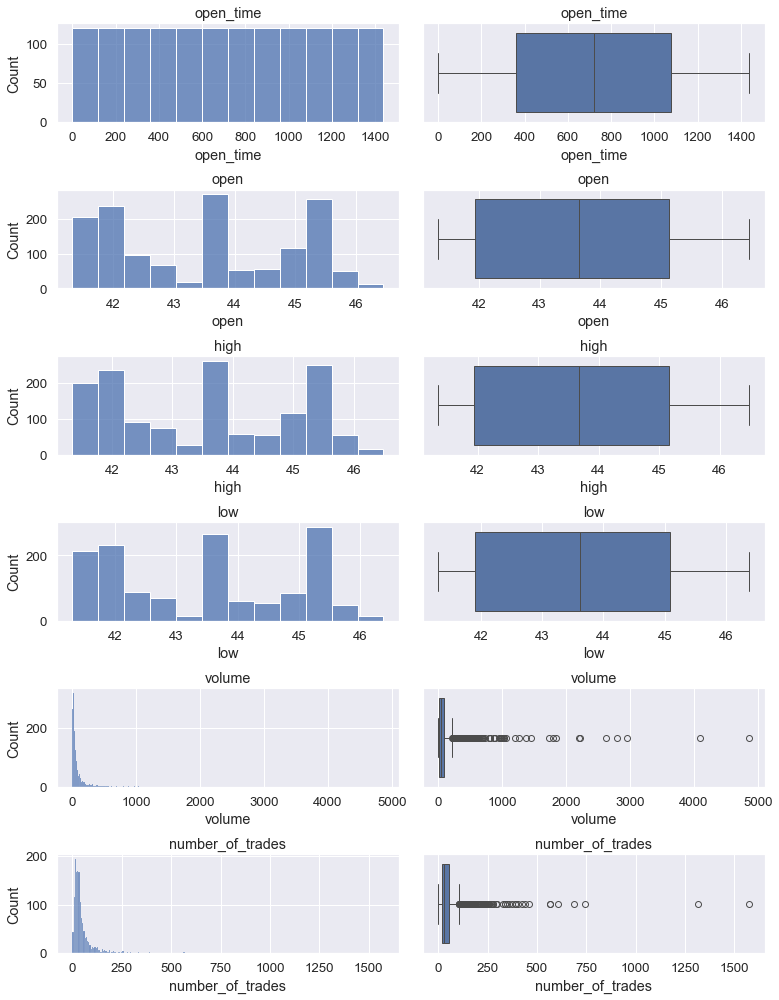

In [12]:
numbers_plot(ILV_USDT, param_hue = None)

У первых признаков на графиках не было замечено определенных выбросов, а вот на последних двух, связанных с продажами, оказалось достаточно много выбросов, что не очень хорошо, так как модели будет достаточно сложно понять эту логику. Посмотрим на другие монеты

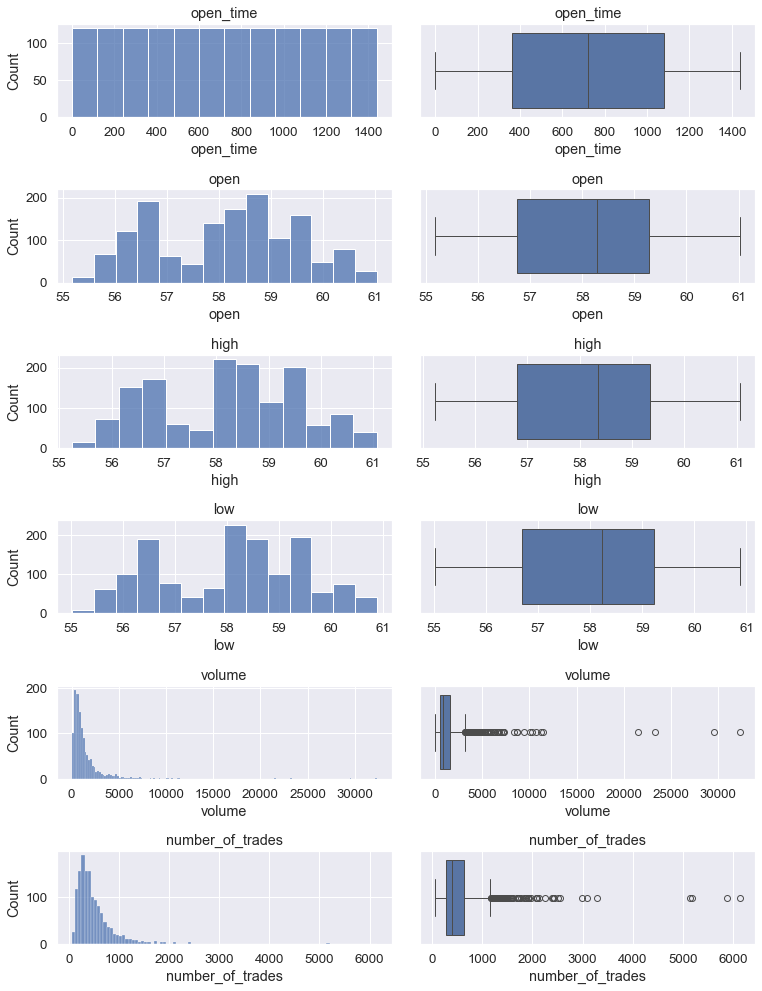

In [13]:
numbers_plot(TRB_USDT, param_hue = None)

Похожая ситуация на прошлую валюту

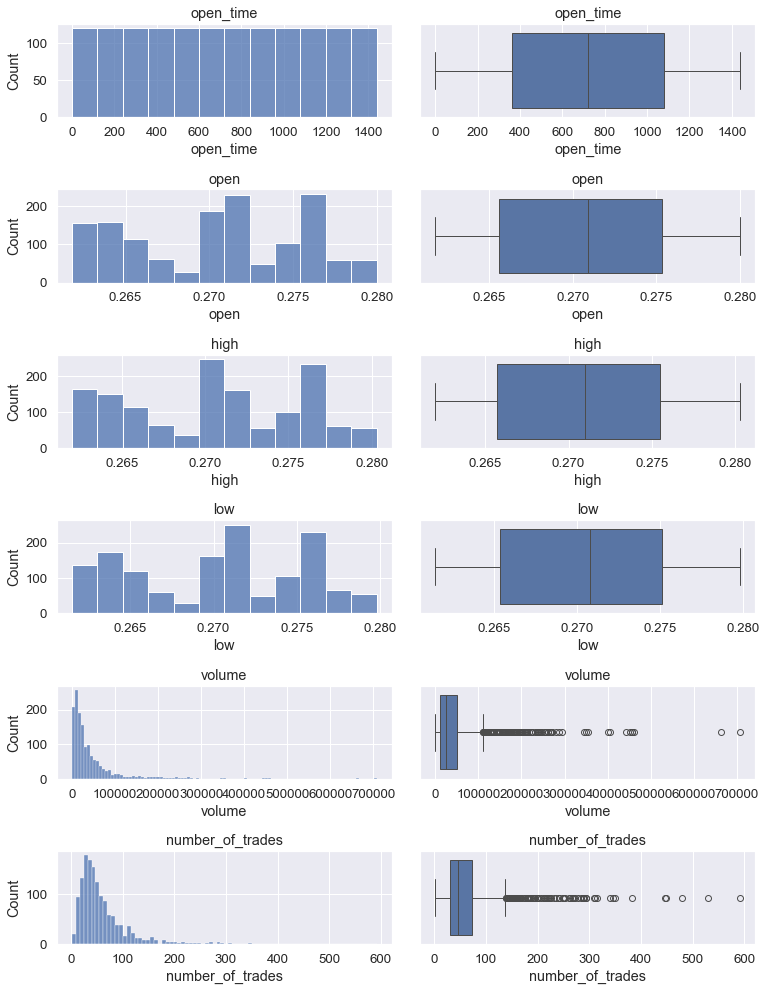

In [14]:
numbers_plot(MANA_USDT, param_hue = None)

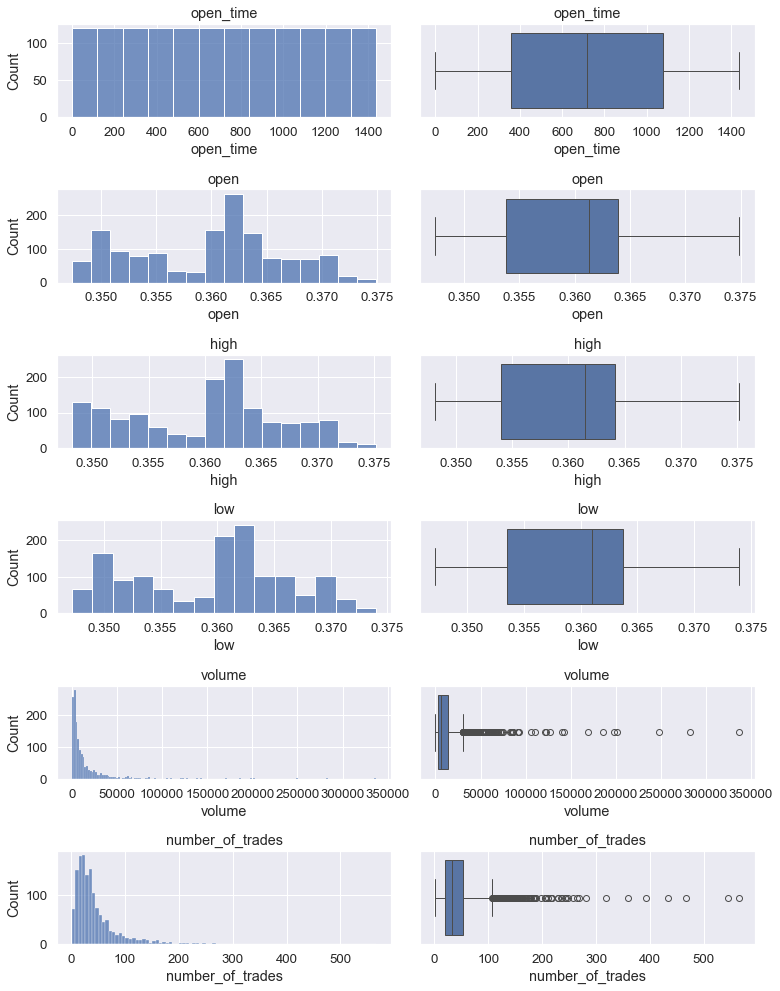

In [15]:
numbers_plot(HOOK_USDT, param_hue = None)

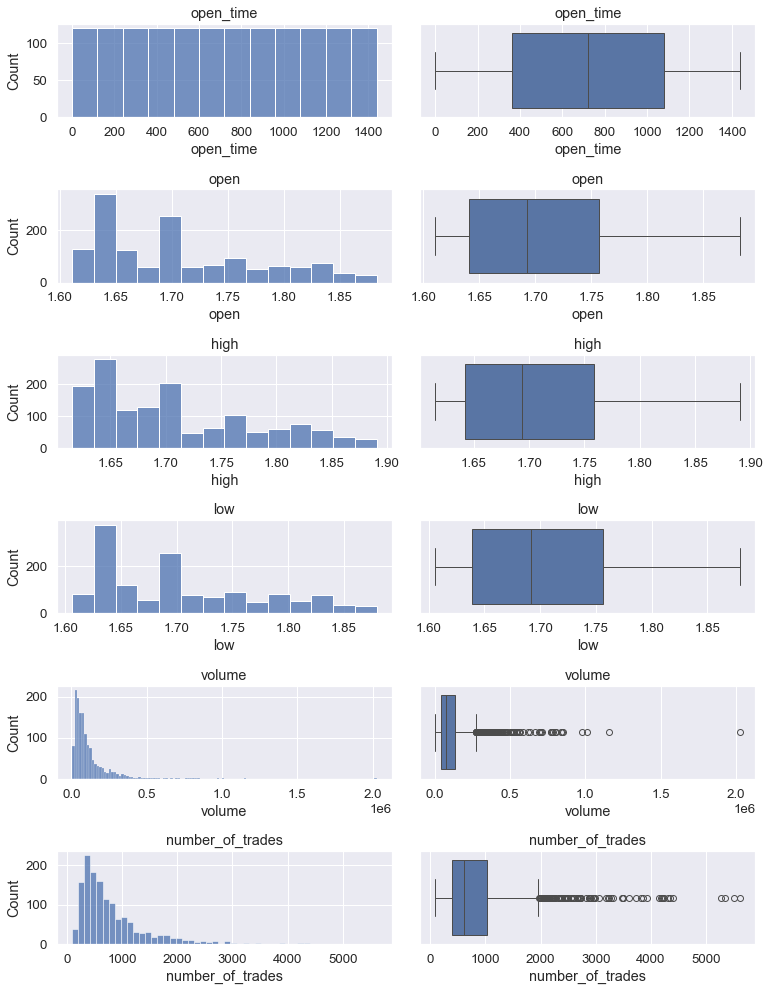

In [16]:
numbers_plot(WLD_USDT, param_hue = None)

Ну и в последних трех графиках происходит похожая ситуация

По гистограммам и ящикам с усами можно сказать, что признаки у монет ведут себя достаточно схоже. Первые, не считая время, имеют несколько бугров. Это показывает непредсказуемое поведение рынка. У последних двух признаков во всех монетах распределения похожи на Пуассона. 

Посмотрим на временные графики. Конечно, у нас практически нет надежд увидеть какую-то сезонность или тренд, особенно за один день, но осведомиться все-таки нужно

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\3475727646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ILV_USDT_sr['mean']= ILV_USDT_sr['open'].shift().rolling(40).mean()


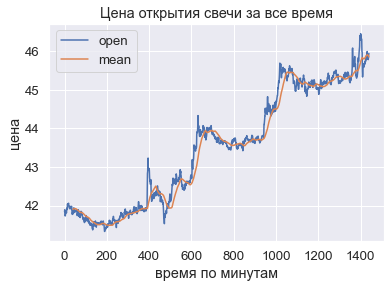

In [17]:
ILV_USDT_sr = ILV_USDT[['open_time', 'open']]
ILV_USDT_sr['mean']= ILV_USDT_sr['open'].shift().rolling(40).mean()
ax = ILV_USDT_sr.plot(x = 'open_time')
ax.set_title("Цена открытия свечи за все время")
ax.set_xlabel("время по минутам")
ax.set_ylabel("цена")
plt.show();

Трнеда и определенной сезонности тут не видно. Хотя про тренд можно сказать, что есть постепенный рост графика, но не очень плавный.  
Теперь попробуем посмортеть на средние показатели цен по часам

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\3409513846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ILV_USDT_sr['open_time_hours'] = (ILV_USDT_sr['open_time'] / 60).astype(int)


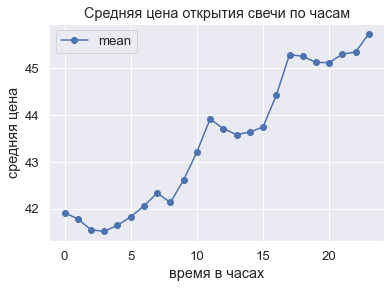

In [18]:
ILV_USDT_sr['open_time_hours'] = (ILV_USDT_sr['open_time'] / 60).astype(int)
ILV_USDT_sr_hourly = ILV_USDT_sr.groupby('open_time_hours').mean()

ax = ILV_USDT_sr_hourly.plot(y='mean', marker='o')
ax.set_title("Средняя цена открытия свечи по часам")
ax.set_xlabel("время в часах")
ax.set_ylabel("средняя цена")
plt.show()

Цены по сравнению с ночью увеличивались с утра до вечера. Можно предположить, что это возможно из-за того, что люди ночью спят и никак не влияют на акции, а в течение дня покупают их, но скорее всего это просто случайность. Посмотрим на другие монеты

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\160573561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TRB_USDT_sr['mean']= TRB_USDT_sr['open'].shift().rolling(40).mean()


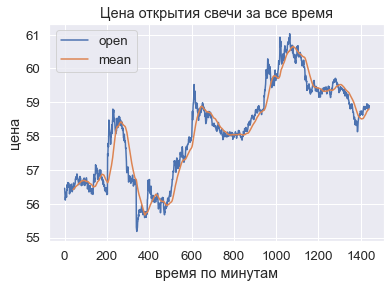

In [19]:
TRB_USDT_sr = TRB_USDT[['open_time', 'open']]
TRB_USDT_sr['mean']= TRB_USDT_sr['open'].shift().rolling(40).mean()
ax = TRB_USDT_sr.plot(x = 'open_time')
ax.set_title("Цена открытия свечи за все время")
ax.set_xlabel("время по минутам")
ax.set_ylabel("цена")
plt.show();

Никакого тренда и сезонности не видать

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\59420713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TRB_USDT_sr['open_time_hours'] = (TRB_USDT_sr['open_time'] / 60).astype(int)


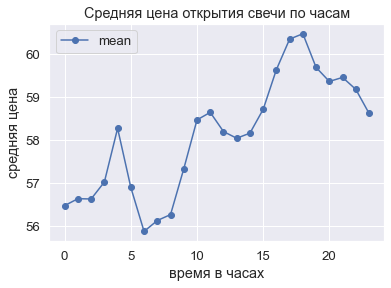

In [20]:
TRB_USDT_sr['open_time_hours'] = (TRB_USDT_sr['open_time'] / 60).astype(int)
TRB_USDT_sr_hourly = TRB_USDT_sr.groupby('open_time_hours').mean()

ax = TRB_USDT_sr_hourly.plot(y='mean', marker='o')
ax.set_title("Средняя цена открытия свечи по часам")
ax.set_xlabel("время в часах")
ax.set_ylabel("средняя цена")
plt.show()

Во время дня цены тоже растут

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\3388744898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MANA_USDT_sr['mean']= MANA_USDT_sr['open'].shift().rolling(40).mean()


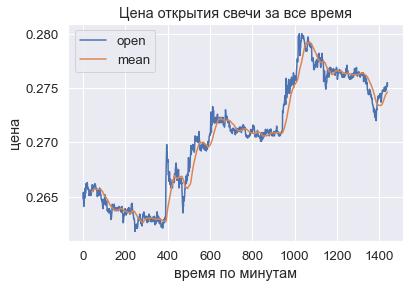

In [21]:
MANA_USDT_sr = MANA_USDT[['open_time', 'open']]
MANA_USDT_sr['mean']= MANA_USDT_sr['open'].shift().rolling(40).mean()
ax = MANA_USDT_sr.plot(x = 'open_time')
ax.set_title("Цена открытия свечи за все время")
ax.set_xlabel("время по минутам")
ax.set_ylabel("цена")
plt.show();

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\4008509544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MANA_USDT_sr['open_time_hours'] = (MANA_USDT_sr['open_time'] / 60).astype(int)


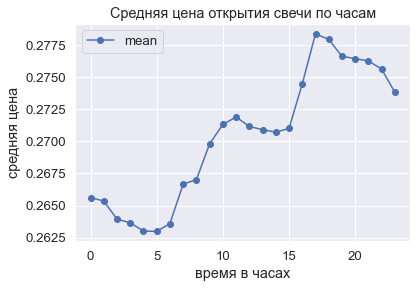

In [22]:
MANA_USDT_sr['open_time_hours'] = (MANA_USDT_sr['open_time'] / 60).astype(int)
MANA_USDT_sr_hourly = MANA_USDT_sr.groupby('open_time_hours').mean()

ax = MANA_USDT_sr_hourly.plot(y='mean', marker='o')
ax.set_title("Средняя цена открытия свечи по часам")
ax.set_xlabel("время в часах")
ax.set_ylabel("средняя цена")
plt.show()

На пртояжении дня также заметене рост цен

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\2318793108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOOK_USDT_sr['mean']= HOOK_USDT_sr['open'].shift().rolling(40).mean()


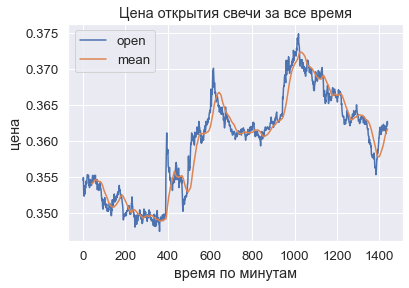

In [23]:
HOOK_USDT_sr = HOOK_USDT[['open_time', 'open']]
HOOK_USDT_sr['mean']= HOOK_USDT_sr['open'].shift().rolling(40).mean()
ax = HOOK_USDT_sr.plot(x = 'open_time')
ax.set_title("Цена открытия свечи за все время")
ax.set_xlabel("время по минутам")
ax.set_ylabel("цена")
plt.show();

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\1450334871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOOK_USDT_sr['open_time_hours'] = (HOOK_USDT_sr['open_time'] / 60).astype(int)


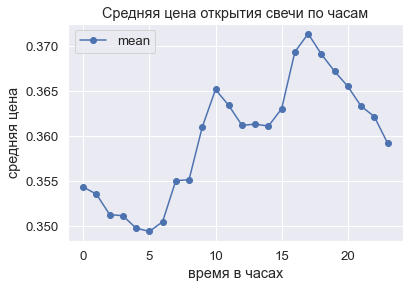

In [24]:
HOOK_USDT_sr['open_time_hours'] = (HOOK_USDT_sr['open_time'] / 60).astype(int)
HOOK_USDT_sr_hourly = HOOK_USDT_sr.groupby('open_time_hours').mean()

ax = HOOK_USDT_sr_hourly.plot(y='mean', marker='o')
ax.set_title("Средняя цена открытия свечи по часам")
ax.set_xlabel("время в часах")
ax.set_ylabel("средняя цена")
plt.show()

In [25]:
WLD_USDT_sr = WLD_USDT[['open_time', 'open']]
WLD_USDT_sr['mean']= WLD_USDT_sr['open'].shift().rolling(40).mean()

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\668662275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WLD_USDT_sr['mean']= WLD_USDT_sr['open'].shift().rolling(40).mean()


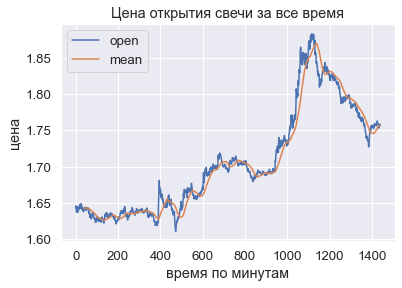

In [26]:
ax = WLD_USDT_sr.plot(x = 'open_time')
ax.set_title("Цена открытия свечи за все время")
ax.set_xlabel("время по минутам")
ax.set_ylabel("цена")
plt.show();

C:\Users\zebra\AppData\Local\Temp\ipykernel_6216\267044439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WLD_USDT_sr['open_time_hours'] = (WLD_USDT_sr['open_time'] / 60).astype(int)


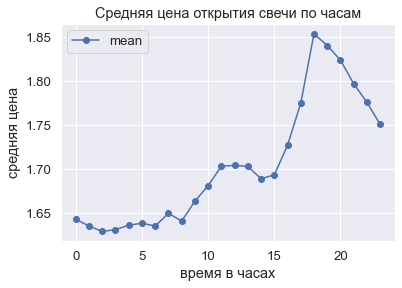

In [27]:
WLD_USDT_sr['open_time_hours'] = (WLD_USDT_sr['open_time'] / 60).astype(int)
WLD_USDT_sr_hourly = WLD_USDT_sr.groupby('open_time_hours').mean()

ax = WLD_USDT_sr_hourly.plot(y='mean', marker='o')
ax.set_title("Средняя цена открытия свечи по часам")
ax.set_xlabel("время в часах")
ax.set_ylabel("средняя цена")
plt.show()

С помощью данных графиков мы в большей степени выдвинули небольшие гипотезы, которые на нашей маленькой выборке нельзя доказать, так как рост цен мог зависеть не только от того, что люди спят или нет. Можно выдвинуть еще одну гипотезу, которая может помочь оценить риски больших инвестиций в кратковременный срок в монеты. У нас это 2 часа. Цена на монеты за такой маленький промежуток времени не сможет упасть более чем на 10%. Проверим это чуть ниже.

## Проверка гипотез

Бытует мнение, что рынок криптовалюты зависит от цены Биткоина, поэтому мы хотим взять и проверить будет ли рости не очень популярная монета из-за роста биткоина либо наоборот - падать из-за падения биткоина. Для этого нам нужно считать такие же данные BTCUSDT, как мы делали для наших монет, посчитать в процентах изменение стоймости валют и сравнить их с помощью библиотеки scipy.stats и теста ttest_ind, так как у нас две разные выборки.  
Пока подготовим данные

In [28]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
    'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

params = {
    'symbol': 'BTCUSDT',
    'interval': '1m',  
    'limit': 1440,
    'startTime': 1723096800000, 
}
url = 'https://fapi.binance.com/fapi/v1/klines'
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    BTC = pd.DataFrame(data, columns=columns)
else:
    print(f'Ошибка {response.status_code}: {response.text}')

In [29]:
BTC = BTC.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
BTC['open_time'] = (BTC['open_time'] - const) / (1000 * 60)
BTC['open_time'] = BTC['open_time'].astype('int')
BTC['open'] = pd.to_numeric(BTC['open'], errors='coerce')

In [30]:
BTC['change'] = BTC['open'].shift(fill_value=0)
BTC['change'] = ((BTC['open'] - BTC['change']) / BTC['open']) * 100
BTC['change'] = round(BTC['change'], 3)
BTC.at[0, 'change'] = 0

In [31]:
ILV_USDT['change'] = ILV_USDT['open'].shift(fill_value=0)
ILV_USDT['change'] = ((ILV_USDT['open'] - ILV_USDT['change']) / ILV_USDT['open']) * 100
ILV_USDT['change'] = round(ILV_USDT['change'], 3)
ILV_USDT.at[0, 'change'] = 0
ILV_USDT.head()

,open_time,open,high,low,volume,number_of_trades,change
0,0,41.840000,41.910000,41.820000,131.899994,71,0.000
1,1,41.889999,41.889999,41.840000,57.200001,49,0.119
2,2,41.830002,41.849998,41.709999,54.200001,48,-0.143
3,3,41.730000,41.750000,41.680000,102.300003,65,-0.240
4,4,41.750000,41.820000,41.740002,62.900002,54,0.048


И последний шаг для подготовки это нужно проверить распределения сравниваемых выборок. Они должны быть похожи

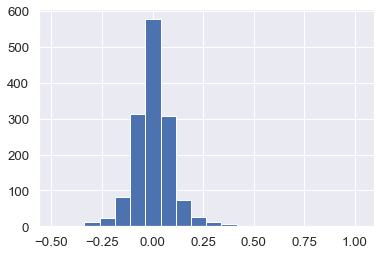

In [32]:
BTC['change'].hist(bins = 20);

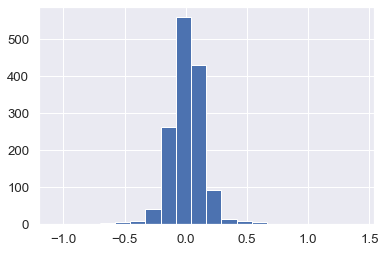

In [33]:
ILV_USDT['change'].hist(bins = 20);

Вот теперь данные готовы для проведения теста. Нулевая гипотеза (H0) у нас будет такая: Монета ILV_USDT зависит от изменения цены BTC. Альтернативная гипотеза (H1): Монета ILV_USDT не зависит от изменения цены BTC

In [34]:
alpha = 0.05

results = st.ttest_ind(BTC['change'], ILV_USDT['change'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.7169633218012745
Не получилось отвергнуть нулевую гипотезу


Это означает, что зависимость есть, так как p-value имеет очень большое значение. Имеет смысл проверить остальные валюты. Сделаем это с помощью среднего значения цены между нашими 5 монетами и сравним их с биткоином.

In [35]:
coins = [ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT]
TRB_USDT['change'] = TRB_USDT['open'].shift(fill_value=0)
TRB_USDT['change'] = ((TRB_USDT['open'] - TRB_USDT['change']) / TRB_USDT['open']) * 100
TRB_USDT['change'] = round(TRB_USDT['change'], 3)
TRB_USDT.at[0, 'change'] = 0

MANA_USDT['change'] = MANA_USDT['open'].shift(fill_value=0)
MANA_USDT['change'] = ((MANA_USDT['open'] - MANA_USDT['change']) / MANA_USDT['open']) * 100
MANA_USDT['change'] = round(MANA_USDT['change'], 3)
MANA_USDT.at[0, 'change'] = 0

HOOK_USDT['change'] = HOOK_USDT['open'].shift(fill_value=0)
HOOK_USDT['change'] = ((HOOK_USDT['open'] - HOOK_USDT['change']) / HOOK_USDT['open']) * 100
HOOK_USDT['change'] = round(HOOK_USDT['change'], 3)
HOOK_USDT.at[0, 'change'] = 0

WLD_USDT['change'] = WLD_USDT['open'].shift(fill_value=0)
WLD_USDT['change'] = ((WLD_USDT['open'] - WLD_USDT['change']) / WLD_USDT['open']) * 100
WLD_USDT['change'] = round(WLD_USDT['change'], 3)
WLD_USDT.at[0, 'change'] = 0

a = (WLD_USDT['change'] + HOOK_USDT['change'] + MANA_USDT['change'] + TRB_USDT['change'] + ILV_USDT['change']) / 5
a.head()

0    0.0000
1    0.0786
2   -0.2386
3   -0.2448
4    0.0278
Name: change, dtype: float32

Можно приступать к проведению теста, но для начала сформулируем гипотезы: H0 - не очень популярные монеты зависят от изменения Биткоина. H1 - не очень популярные монеты не зависят от изменения Биткоина

In [36]:
alpha = 0.05

results = st.ttest_ind(BTC['change'], a)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.788720946120373
Не получилось отвергнуть нулевую гипотезу


Грубо говоря, получается, что рынок криптовалюты зависит от изменения биткоина, поэтому можно добавить к нашим признакам для какждой монеты еще один - это цена биткоина

In [37]:
coins = [ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT]
ILV_USDT['btc'] = BTC['open']
TRB_USDT['btc'] = BTC['open']
MANA_USDT['btc'] = BTC['open']
HOOK_USDT['btc'] = BTC['open']
WLD_USDT['btc'] = BTC['open']

**Вторая гипотеза**

С помощью часовых графиков, которые мы построили на прошлом этапе, когда анализировали временные ряды, проверим, насколько сильно может упасть стоймость монеты в процентах за один час, так как именно в этом окне мы будем покупать или продавать монету. Это поможет оценить риски компании.  
Для этого нам нужно взять прошлые датасеты, как: MANA_USDT_sr и создать столбец, который будет показывать изменение цены монеты в процентах за каждый час. Сделаем это для каждого датафрейма и объединим все значения в один, чтобы выборка получилась больше.

In [38]:
ILV_USDT_h = ILV_USDT_sr[['open_time_hours', 'open']].groupby('open_time_hours').agg({'open': ['min', 'max']})
ILV_USDT_h['change'] = -1 * ((ILV_USDT_h['open']['max'] - ILV_USDT_h['open']['min']) / ILV_USDT_h['open']['max']) * 100

TRB_USDT_h = TRB_USDT_sr[['open_time_hours', 'open']].groupby('open_time_hours').agg({'open': ['min', 'max']})
TRB_USDT_h['change'] = -1 * (TRB_USDT_h['open']['max'] - TRB_USDT_h['open']['min']) / TRB_USDT_h['open']['max'] * 100

MANA_USDT_h = MANA_USDT_sr[['open_time_hours', 'open']].groupby('open_time_hours').agg({'open': ['min', 'max']})
MANA_USDT_h['change'] = -1 * (MANA_USDT_h['open']['max'] - MANA_USDT_h['open']['min']) / MANA_USDT_h['open']['max'] * 100

HOOK_USDT_h = HOOK_USDT_sr[['open_time_hours', 'open']].groupby('open_time_hours').agg({'open': ['min', 'max']})
HOOK_USDT_h['change'] = -1 * (HOOK_USDT_h['open']['max'] - HOOK_USDT_h['open']['min']) / HOOK_USDT_h['open']['max'] * 100

WLD_USDT_h = WLD_USDT_sr[['open_time_hours', 'open']].groupby('open_time_hours').agg({'open': ['min', 'max']})
WLD_USDT_h['change'] = -1 * (WLD_USDT_h['open']['max'] - WLD_USDT_h['open']['min']) / WLD_USDT_h['open']['max'] * 100

result = pd.concat([ILV_USDT_h['change'], TRB_USDT_h['change'], MANA_USDT_h['change'], HOOK_USDT_h['change'], WLD_USDT_h['change']])
result

open_time_hours
0    -0.784598
1    -0.907140
2    -0.552884
3    -0.934802
4    -1.145310
        ...   
19   -1.833569
20   -2.232312
21   -1.011732
22   -2.755842
23   -2.013730
Name: change, Length: 120, dtype: float32

Данные готовы. Осталось только применить ttest_1sMANA, чтобы понять: может ли в среднем за 1 час уменьшиться цена на 1.5%, если рассматривать только случаи падения цены у валюты?  
Формулируем две гипотезы:
* H0: Среднее сзначение процентного падения в цене не превышает 1.5%
* H1: Среднее сзначение процентного падения в цене превышает 1.5%

In [39]:
result = -1 * result # домножим результаты на -1, чтобы не запутаться в выводе
print(result.mean())

prev_screens_value = 1.5
alpha = 0.05
results = st.ttest_1samp(
    result, 
    prev_screens_value,
    alternative = 'greater'
      )
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

1.5226438
p-значение: 0.3973850910376724
Не отвергаем нулевую гипотезу


Получается, что очень маловероятно резкое падание при котором компания очень много потеряет. Обычно, за один час монета не может стать дешевле более чем на 1.5%, что очень мало. Особенно, если у нас будет модель, которая не допустит такого провала. На что мы очень сильно надеемся.

Данный шаг позади. Мы проверили гипотезы, которые оказались верными. Первая гипотеза была про то что цена биткоина влияет на стоймость монеты ILV_USDT и других не таких дорогих и популярных криптовалют. Благодаря этому мы добавили новый признак в наши таблицы, а именно - цена биткоина. Еще одной гипотезой мы проверили, как много сможем потерять денег, если наша модель сильно ошибется или что-то пойдет не так. 

## Корреляционный анализ признаков

Суть данного шага в том, чтобы посмотреть на зависимость признаков, из которых мы будем создавать другие с помощью задержки shift и скользящего среднего, поэтому нам нужно подобрать хоршие и нужные признаки, чтобы модель получилась хорошей

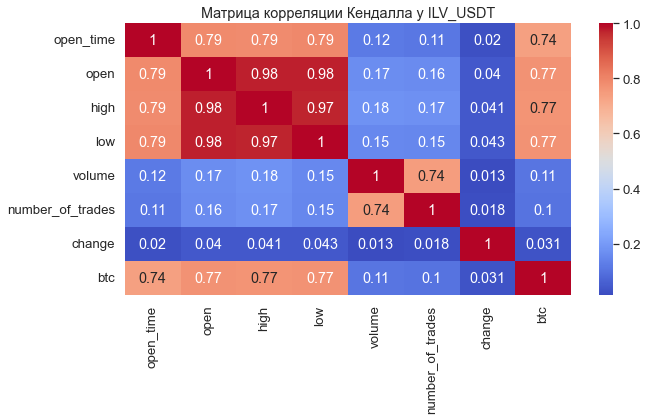

In [40]:
correlation_matrix = ILV_USDT.corr(method='kendall')
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Кендалла у ILV_USDT')
plt.show()

Можно заметить, что очень сильная корреляция у open с high, low. Возможно стоило взять свечи с большим интервалом (5 минут), но тогда у нас бы модель уже обучалась больше на долгосрочную перспективу, чем на точный анализ двух часов. Возможно стоит проверить и эту так сказать гипотезу. Новый признак btc оправдал свои ожиданияю Плохо себя проявил признак change. У него слишком слабая корреляция со всеми. Скорее всего его стоит удалить

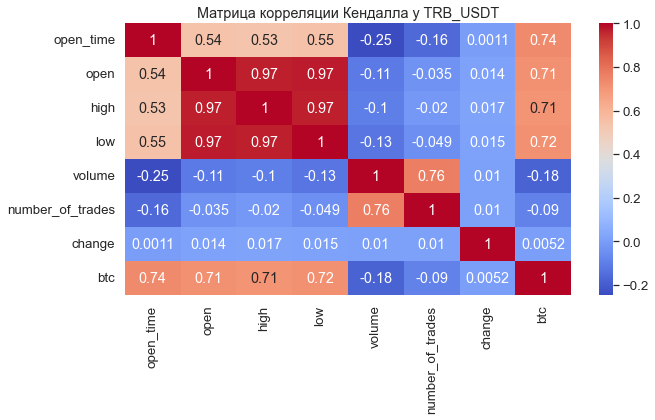

In [41]:
correlation_matrix = TRB_USDT.corr(method='kendall')
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Кендалла у TRB_USDT')
plt.show()

По сравнению с прошлой монетой имеются изменения, но не сильные.

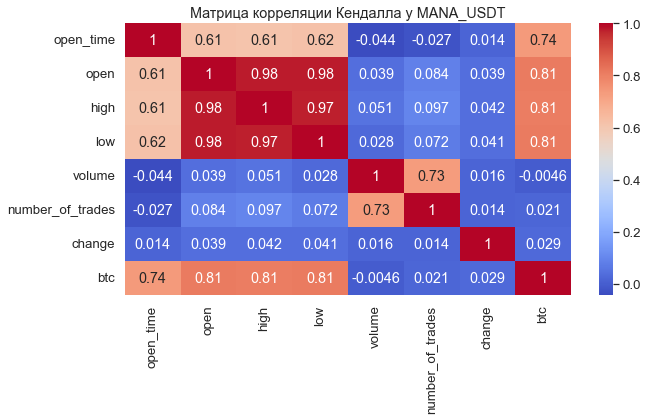

In [42]:
correlation_matrix = MANA_USDT.corr(method='kendall')
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Кендалла у MANA_USDT')
plt.show()

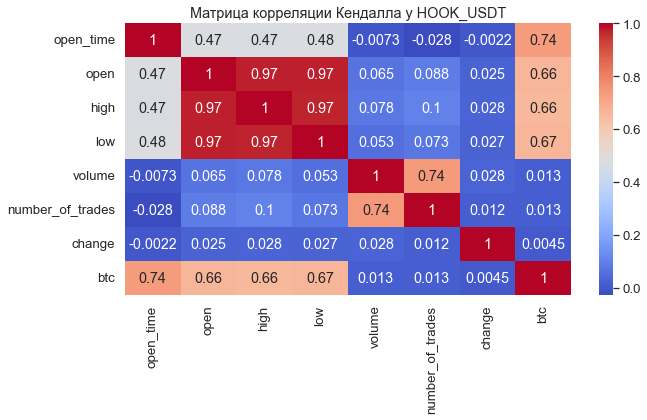

In [43]:
correlation_matrix = HOOK_USDT.corr(method='kendall')
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Кендалла у HOOK_USDT')
plt.show()

В двух матрицах можно заметить не такую сильную зависимость признаков open_time с open, high, low, как у других. Возможно у них из-за резких изменений графика получилась не совсем линейная зависимость

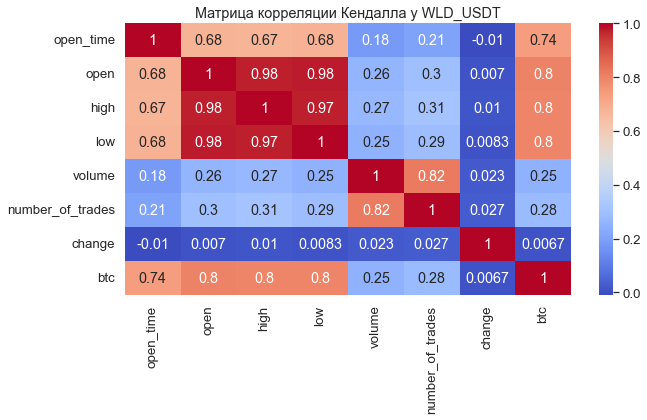

In [44]:
correlation_matrix = WLD_USDT.corr(method='kendall')
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Кендалла у WLD_USDT')
plt.show()

Можно заметить, что с целевым признаком open больше всего взаимодействуют high, low. Ну и немного меньше btc и время открытия свечи. Признак change имеет слишком маленькую корреляцию. Его стоит удалить

In [45]:
coins = [ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT]
ILV_USDT = ILV_USDT.drop('change', axis = 1)
TRB_USDT = TRB_USDT.drop('change', axis = 1)
MANA_USDT = MANA_USDT.drop('change', axis = 1)
HOOK_USDT = HOOK_USDT.drop('change', axis = 1)
WLD_USDT = WLD_USDT.drop('change', axis = 1)

На данном шаге посмотрели на зависимость признаков, из которых мы создадим другие с помощью задержки shift и скользящего среднего, поэтому нам нужно подобрать хоршие и нужные признаки, чтобы модель получилась хорошей. Была заметна очень сильная корреляция у open с high, low. Возможно стоило взять свечи с большим интервалом (5 минут), но тогда у нас бы модель уже обучалась больше на долгосрочную перспективу, чем на точный анализ двух часов. Возможно стоит проверить и эту так сказать гипотезу. Новый признак btc оправдал свои ожиданияю Плохо себя проявил признак change. У него слишком слабая корреляция со всеми, поэтому его пришлось удалить. Переходим к долгожданному... Создание моделей

## Создание моделей

На данном этапе нам предстоит среди большого количества моделей, их параметров и переборов иннтервалов между свечами выбрать лучшее, что сможет помочь нам точнее предсказать ход графиков цен монет. Перебирать параметры мы будем с помощью GridSearchCV с параметром cv=5. Будем использовать метрику RMSE и потроим наглядные гшрафики, которые лучше всего помогут увидеть разницу в тестовых и предсказанных результатах. TEST_SIZE сделаем 0.1, чтобы предсказывать последние два с половиной часа. С помощью функции make_features будем создавать признаки задержки shift и скользящее среднее *на 1 интервал*  
Чтобы занимать меньше объема в тетради, воспользуемся функцией prognoz. На вход ей подаем монету, модель и параметры для модели. На выходе получим метрки RMSE, MAE для каждого случая перебора временных признаков и график, где наложены линия предикта и теста

max_lag = 1
rolling_mean_size = 1
0.02886545047500212
MAE: 0.02905151012208989

max_lag = 1
rolling_mean_size = 3
0.02922439111651474
MAE: 0.0299736749480966

max_lag = 3
rolling_mean_size = 1
0.029328054292723862
MAE: 0.03026241629487029

max_lag = 3
rolling_mean_size = 3
0.029417917710197736
MAE: 0.030109750787982986



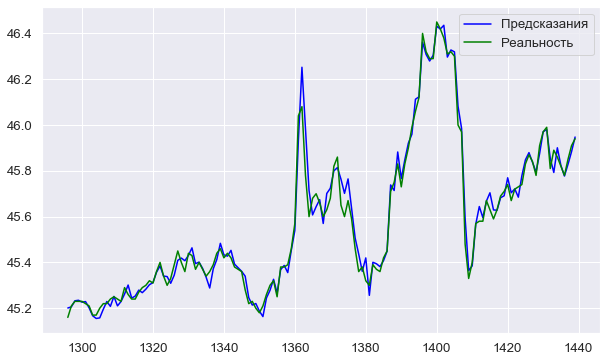

In [46]:
param_grid = {}
ILV_USDT_lr = ILV_USDT.copy()
prognoz(ILV_USDT_lr, LinearRegression(), param_grid)

График получился очень точным, но не один в один, поэтому это не утечка данных. **На самом деле это из-за того, что мы берем очень маленький интервал свечей в одну минуту. За такой маленький промежуток времени цена практически не успевает измениться** 

Посмотрим на еще одну монету с помощью линейной регрессии TRB_USDT

max_lag = 1
rolling_mean_size = 1
0.04282070598590661
MAE: 0.019552085134718154

max_lag = 1
rolling_mean_size = 3
0.042574399928134866
MAE: 0.018636011373602133

max_lag = 3
rolling_mean_size = 1
0.0430049774869402
MAE: 0.01851959476450323

max_lag = 3
rolling_mean_size = 3
0.04306243199322394
MAE: 0.018557068579856544



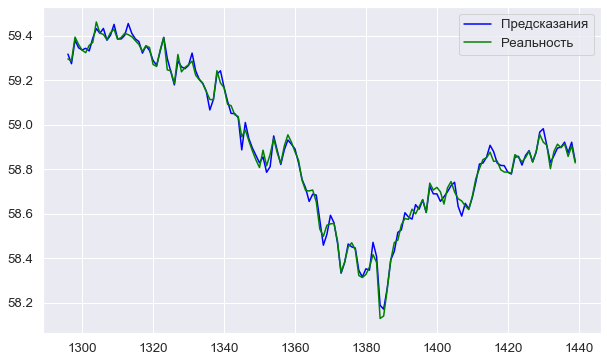

In [47]:
param_grid = {}
TRB_USDT_lr = TRB_USDT.copy()
prognoz(TRB_USDT_lr, LinearRegression(), param_grid)

Результаты тоже получились точные. Посмотрим, как проявят себя другие модели

max_lag = 1
rolling_mean_size = 1
0.11986632056177696
MAE: 0.13517081888855165

max_lag = 1
rolling_mean_size = 3
0.12796071242492693
MAE: 0.1353229699521676

max_lag = 3
rolling_mean_size = 1
0.10751903452602851
MAE: 0.1300786262801572

max_lag = 3
rolling_mean_size = 3
0.10600423783384169
MAE: 0.1296532948811849



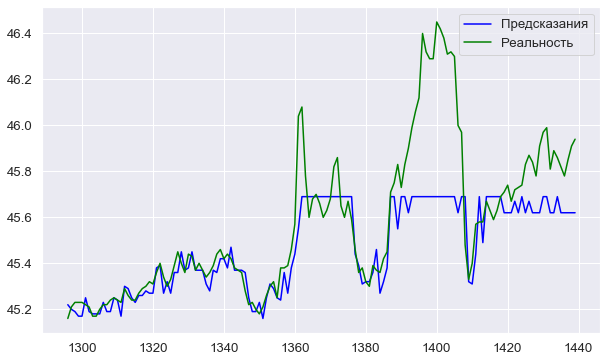

In [48]:
RANDOM_STATE = 42
param_grid = {
    'max_depth': [8, 20, 60, None],
    'min_samples_split': [2, 10, 20],
}
ILV_USDT_dt = ILV_USDT.copy()
prognoz(ILV_USDT_dt, DecisionTreeRegressor(random_state = RANDOM_STATE), param_grid)

К сожалению дерево решений просто не смогло справиться, так как можно заметить, что график предсказаний на определенном значении просто не может подняться выше, что очень странно. Видимо это из-за того, что модель не обучалась на таких выбросах. Давайте посмотрим на градиентный бустинг

max_lag = 1
rolling_mean_size = 1
0.12051286733501121
MAE: 0.1612845856403087

max_lag = 1
rolling_mean_size = 3
0.14591117305080523
MAE: 0.16338464622124313

max_lag = 3
rolling_mean_size = 1
0.1416391504454211
MAE: 0.1600839625246508

max_lag = 3
rolling_mean_size = 3
0.1414111412553243
MAE: 0.1631628996850757



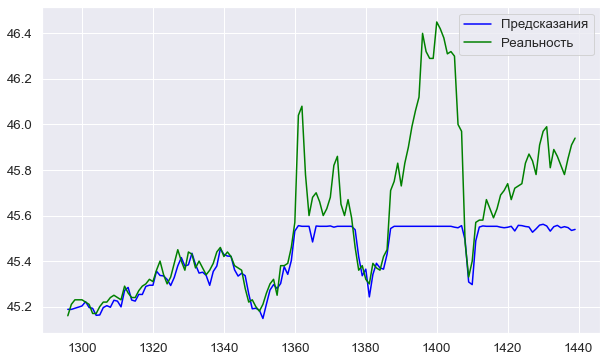

In [49]:
RANDOM_STATE = 42
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [20, 50, 100]
}
ILV_USDT_lgbm = ILV_USDT.copy()

prognoz(ILV_USDT_lgbm, LGBMRegressor(seed=RANDOM_STATE, verbosity=-1), param_grid)

Странно. Уже во второй подряд модели, на которую мы расчитывали, появляется ограничение в значениях цены, как и в деревьях. Может это и вправду из-за недообучения? Модель не сталкивалась с такими значениями и не знает что делать. Чтобы это проверить давайте посмотрим на максимальное значения цены в тренировочной выборке, по которой училась модель

In [50]:
ILV_USDT.loc[:1300, 'open'].max()

45.69

Наша гипотеза подтвердилась. Максимальное значение, которое видела наша модель это 45.69, а на графике встречаются намного больше. Теперь будем проверять наши модели на другой монете.  
**Сделаем вывод, что линейная регрессия лучше реагирует на выбросы, которые не встречались во время обучения, а в криптовалюте возможно все.** Может стоит просто брать больше тренировочных данных, но это не гарантирует исчезновение такой проблемы. Нужно дальше анализировать наши модели

max_lag = 1
rolling_mean_size = 1
0.18865392491955474
MAE: 0.02892775282754472

max_lag = 1
rolling_mean_size = 3
0.17605739626875386
MAE: 0.02725646770326959

max_lag = 3
rolling_mean_size = 1
0.1794104623366375
MAE: 0.02788387132249559

max_lag = 3
rolling_mean_size = 3
0.17716836746568929
MAE: 0.027714007175335946



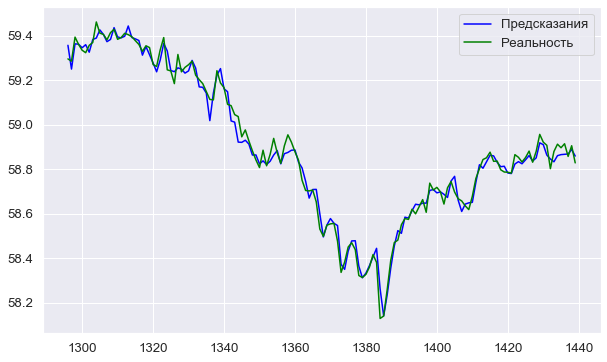

In [51]:
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [20, 50, 100]
}
TRB_USDT_lgbm = TRB_USDT.copy()

prognoz(TRB_USDT_lgbm, LGBMRegressor(seed=RANDOM_STATE, verbosity=-1), param_grid)

Запомним такой минус для таких моделей. Даже при большей выборке у нас не может быть гарантии, что мы встретимся с такими значениями. Мы постараемся с этим побороться, но немного позже. Давайте допроверим оставшиеся модели и сделаем небольшие выводы по интервалу свечей в 1 минуту

Из-за нехватки опыта в данной сфере мне достаточно сложно определить насколько возможно постоянно считывать данные свечей в интервале в 1 минуту, чтобы делать предсказания точнее. Давайте посмотрим, что будет, если мы возьмем интервал уже в 10 минут? Насколько сильно это повлияет на наш результат? Для этого перезапишем функцию make_features, которая создает временные признаки на расстоянии не 1, а уже 10.

In [52]:
def make_features(data, max_lag, rolling_mean_size, columns): 
    for column in columns:
        for lag in range(1, max_lag + 1):
            new_column_name = f'lag_{column}_{lag + 9}'  # добавляем 9 для задержки в 10
            data[new_column_name] = data[column].shift(lag + 9)  # добавляем 35 для задержки в 10
        data[f'rolling_mean_{column}'] = data[column].shift(9).rolling(rolling_mean_size).mean()  # добавляем 35 для задержки в 10

max_lag = 1
rolling_mean_size = 1
0.3249746992621757
MAE: 0.14586189046179365

max_lag = 1
rolling_mean_size = 3
0.3327349308621545
MAE: 0.14803588688041244

max_lag = 3
rolling_mean_size = 1
0.3301588387230215
MAE: 0.15292549010718484

max_lag = 3
rolling_mean_size = 3
0.3301588387230222
MAE: 0.152925490107184



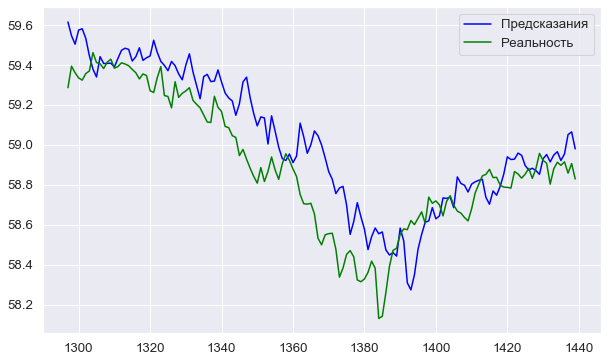

In [53]:
param_grid = {}
TRB_USDT_lr_10 = TRB_USDT.copy()
prognoz(TRB_USDT_lr_10, LinearRegression(), param_grid)

Уже при задержке на 10 минут линейная регрессия не справляется. А что будет при большей задержке можно и не проверять. Может другие модели лучше справятся с этим заданием?

max_lag = 1
rolling_mean_size = 1
0.748281557730691
MAE: 0.6395528794119556

max_lag = 1
rolling_mean_size = 3
0.8196527100554468
MAE: 0.5615848928064733

max_lag = 3
rolling_mean_size = 1
0.9369125032512706
MAE: 0.6358384415231484

max_lag = 3
rolling_mean_size = 3
0.9293551167780025
MAE: 0.7076996383133463



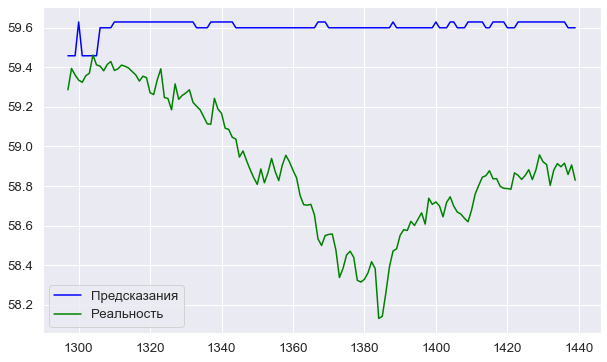

In [54]:
param_grid = {
    'max_depth': [8, 20, 60, None],
    'min_samples_split': [2, 10, 20],
}
TRB_USDT_dt_10 = TRB_USDT.copy()
prognoz(TRB_USDT_dt_10, DecisionTreeRegressor(random_state = RANDOM_STATE), param_grid)

Результаты тоже плачевны. С задержкой в 10 минут модели просто не справляется. Другие я не вставил, чтобы они не загромождали тетрадку, но они также не справились. Нам стоит либо вернуться к предсказаниям цены с задержкой значений на 1 минуту, либо попробовать взять другой интервал свечей. Например в 30 минут. Так как чем больше шагов вперед мы предсказываем, тем быстрее и сильнее модель уходит с правильного пути. Думаю, стоит проверить наш второй вариант. Для этого считаем данные уже двух монет 'ILVUSDT', 'TRBUSDT', которые будем проверять. Интервал свечей поставим в 30мин, а кол-во данных 1000, так как по-прошлому опыту мы поняли, что обучающие данные стоит брать с запасом. Время для начала считывания возьмем пораньше, а то не хватит данных

In [55]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
    'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

symbols = ['ILVUSDT', 'TRBUSDT', 'MANAUSDT', 'HOOKUSDT', 'WLDUSDT', 'BTCUSDT']

dfs = []

for symbol in symbols:
    params = {
        'symbol': symbol,
        'interval': '30m',  
        'limit': 1000,
        'startTime': 1720096800000, 
    }
    url = 'https://fapi.binance.com/fapi/v1/klines'
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data, columns=columns)
        dfs.append(df)  
    else:
        print(f'Ошибка {response.status_code}: {response.text}')
ILV_USDT_30m = dfs[0]
TRB_USDT_30m = dfs[1]
MANA_USDT_30m = dfs[2]
HOOK_USDT_30m = dfs[3]
WLD_USDT_30m = dfs[4]
BTC_USDT_30m = dfs[5]

In [56]:
ILV_USDT_30m = ILV_USDT_30m.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
TRB_USDT_30m = TRB_USDT_30m.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
MANA_USDT_30m = MANA_USDT_30m.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
HOOK_USDT_30m = HOOK_USDT_30m.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
WLD_USDT_30m = WLD_USDT_30m.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
BTC_USDT_30m = BTC_USDT_30m.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)

In [57]:
print('Таблица ILV_USDT:')
display(ILV_USDT_30m.head())
print(ILV_USDT_30m.shape)
print()

print('Таблица TRB_USDT:')
display(TRB_USDT_30m.head())
print(TRB_USDT_30m.shape)
print()

print('Таблица MANA_USDT:')
display(MANA_USDT_30m.head())
print(MANA_USDT_30m.shape)
print()

print('Таблица HOOK_USDT:')
display(HOOK_USDT_30m.head())
print(HOOK_USDT_30m.shape)
print()

print('Таблица WLD_USDT:')
display(WLD_USDT_30m.head())
print(WLD_USDT_30m.shape)
print()

print('Таблица BTC_USDT:')
display(BTC_USDT_30m.head())
print(BTC_USDT_30m.shape)
print()

Таблица ILV_USDT:


,open_time,open,high,low,volume,number_of_trades
0,1720098000000,59.41000,59.75000,57.99000,7488.7,4745
1,1720099800000,58.44000,59.39000,58.32000,3933.0,3962
2,1720101600000,59.27000,59.48000,58.43000,2660.3,2054
3,1720103400000,58.61000,59.08000,58.36000,1544.6,1780
4,1720105200000,58.91000,59.10000,58.50000,1228.7,1188


(1000, 6)

Таблица TRB_USDT:


,open_time,open,high,low,volume,number_of_trades
0,1720098000000,84.602,84.909,82.527,102169.9,36841
1,1720099800000,82.904,85.530,82.841,59479.9,23921
2,1720101600000,85.182,85.618,84.364,27649.2,12295
3,1720103400000,84.663,85.221,84.299,20652.2,10224
4,1720105200000,84.815,85.007,84.035,14859.2,7536


(1000, 6)

Таблица MANA_USDT:


,open_time,open,high,low,volume,number_of_trades
0,1720098000000,0.2997,0.2999,0.2937,6340273,8656
1,1720099800000,0.2948,0.3006,0.2944,2767917,4036
2,1720101600000,0.3000,0.3010,0.2979,1336308,2623
3,1720103400000,0.2990,0.3013,0.2984,1310218,2337
4,1720105200000,0.3013,0.3013,0.2986,1946434,2737


(1000, 6)

Таблица HOOK_USDT:


,open_time,open,high,low,volume,number_of_trades
0,1720098000000,0.492300,0.492800,0.480100,998177.4,4874
1,1720099800000,0.481500,0.491500,0.481200,468814.0,2812
2,1720101600000,0.490900,0.492400,0.485300,218141.6,1581
3,1720103400000,0.487500,0.491700,0.485400,278241.7,1754
4,1720105200000,0.489900,0.490800,0.486800,204854.7,1442


(1000, 6)

Таблица WLD_USDT:


,open_time,open,high,low,volume,number_of_trades
0,1720098000000,2.2343000,2.2611000,2.2002000,13423306,101340
1,1720099800000,2.2510000,2.2856000,2.2366000,12040779,90109
2,1720101600000,2.2496000,2.2620000,2.2301000,5930835,50369
3,1720103400000,2.2534000,2.2589000,2.2099000,8639653,68839
4,1720105200000,2.2502000,2.2511000,2.2192000,4398277,40445


(1000, 6)

Таблица BTC_USDT:


,open_time,open,high,low,volume,number_of_trades
0,1720098000000,57234.30,57449.00,56769.20,24653.873,216670
1,1720099800000,56922.00,57485.00,56750.00,20356.851,197426
2,1720101600000,57402.20,57525.70,56825.40,11767.742,111936
3,1720103400000,56994.40,57489.40,56900.00,9876.025,111000
4,1720105200000,57433.90,57638.90,57336.90,7174.948,79047


(1000, 6)



In [58]:
columns = ['open_time', 'open', 'high', 'low','volume', 'number_of_trades']
coins = [ILV_USDT_30m, TRB_USDT_30m, MANA_USDT_30m, HOOK_USDT_30m, WLD_USDT_30m]
for coin in coins:
    for column in columns:
        coin[column] = pd.to_numeric(coin[column], errors='coerce')
    print(coin.info())

ILV_USDT_30m['btc'] = BTC_USDT_30m['open']
TRB_USDT_30m['btc'] = BTC_USDT_30m['open']
MANA_USDT_30m['btc'] = BTC_USDT_30m['open']
HOOK_USDT_30m['btc'] = BTC_USDT_30m['open']
WLD_USDT_30m['btc'] = BTC_USDT_30m['open']

const = ILV_USDT_30m.loc[0, 'open_time']
ILV_USDT_30m['open_time'] = (ILV_USDT_30m['open_time'] - const) / (1000 * 60) #  перевод из мс в м
ILV_USDT_30m['open_time'] = ILV_USDT_30m['open_time'].astype('int')

const = TRB_USDT_30m.loc[0, 'open_time']
TRB_USDT_30m['open_time'] = (TRB_USDT_30m['open_time'] - const) / (1000 * 60) #  перевод из мс в м
TRB_USDT_30m['open_time'] = TRB_USDT_30m['open_time'].astype('int')

const = MANA_USDT_30m.loc[0, 'open_time']
MANA_USDT_30m['open_time'] = (MANA_USDT_30m['open_time'] - const) / (1000 * 60) #  перевод из мс в м
MANA_USDT_30m['open_time'] = MANA_USDT_30m['open_time'].astype('int')

const = HOOK_USDT_30m.loc[0, 'open_time']
HOOK_USDT_30m['open_time'] = (HOOK_USDT_30m['open_time'] - const) / (1000 * 60) #  перевод из мс в м
HOOK_USDT_30m['open_time'] = HOOK_USDT_30m['open_time'].astype('int')

const = WLD_USDT_30m.loc[0, 'open_time']
WLD_USDT_30m['open_time'] = (WLD_USDT_30m['open_time'] - const) / (1000 * 60) #  перевод из мс в м
WLD_USDT_30m['open_time'] = WLD_USDT_30m['open_time'].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open_time         1000 non-null   int64  
 1   open              1000 non-null   float64
 2   high              1000 non-null   float64
 3   low               1000 non-null   float64
 4   volume            1000 non-null   float64
 5   number_of_trades  1000 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 47.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open_time         1000 non-null   int64  
 1   open              1000 non-null   float64
 2   high              1000 non-null   float64
 3   low               1000 non-null   float64
 4   volume            1000 non-null   float64
 5   number_of_trades  1000 n

In [59]:
ILV_USDT_30m.head()

,open_time,open,high,low,volume,number_of_trades,btc
0,0,59.41,59.75,57.99,7488.7,4745,57234.30
1,30,58.44,59.39,58.32,3933.0,3962,56922.00
2,60,59.27,59.48,58.43,2660.3,2054,57402.20
3,90,58.61,59.08,58.36,1544.6,1780,56994.40
4,120,58.91,59.10,58.50,1228.7,1188,57433.90


In [60]:
TRB_USDT_30m.head()

,open_time,open,high,low,volume,number_of_trades,btc
0,0,84.602,84.909,82.527,102169.9,36841,57234.30
1,30,82.904,85.530,82.841,59479.9,23921,56922.00
2,60,85.182,85.618,84.364,27649.2,12295,57402.20
3,90,84.663,85.221,84.299,20652.2,10224,56994.40
4,120,84.815,85.007,84.035,14859.2,7536,57433.90


На опыте быстренько получили данные, готовые к обучению. Перезаписываем функцию make_features, чтобы сделать лаг 1 и функцию модели, чтобы тестовая выборка была не такой огромной

In [61]:
# функция созданич указанного кол-ва новых признаков. Это лаги и скользящее среднее
def make_features(data, max_lag, rolling_mean_size, columns):
    for column in columns:
        for lag in range(1, max_lag + 1):
            new_column_name = f'lag_{column}_{lag}' 
            data[new_column_name] = data[column].shift(lag)
        data[f'rolling_mean_{column}'] = data[column].shift().rolling(rolling_mean_size).mean()

In [62]:
# обучение модели, получение предсказаний и графика
def prognoz(data, model, param_grid):
    columns = ['open', 'high', 'low', 'volume', 'number_of_trades', 'btc']
    TEST_SIZE = 0.005
    RANDOM_STATE = 42
    params = [1, 3]
    for i in params:
        for j in params:
            make_features(data, i, j, columns) # создаем временные признаки
            X = data.drop(['open', 'high', 'low', 'volume', 'number_of_trades', 'btc'], axis=1) # удаляем спойлеры
            y = data['open']
            q = len(X)
            X = X.dropna() # удаляем первые строки с пропусками из-за создания временных признаков
            w = len(X)
            y = y[q - w:]
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
            scaler = StandardScaler()
            X_train_scaler = scaler.fit_transform(X_train)
            X_test_scaler = scaler.transform(X_test)
            
            model = model
            gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
            gs.fit(X_train_scaler, y_train)
            predictions = gs.predict(X_test_scaler)
            best_rmse_1 = (-gs.best_score_)**0.5
            mae = mean_absolute_error(y_test, predictions)
            print(f'max_lag = {i}')
            print(f'rolling_mean_size = {j}')
            print(best_rmse_1)
            print(f'MAE: {mae}')
            print()
            best_model = gs.best_estimator_
            print(best_model)

    predic = pd.DataFrame(predictions, columns=['предсказания'])
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, predic, label='Предсказания', color='blue')
    plt.plot(y_test.index, y_test, label='Реальность', color='green')
    plt.legend()
    plt.show()

max_lag = 1
rolling_mean_size = 1
0.2160335425001702
MAE: 0.12436734583202451

LinearRegression()
max_lag = 1
rolling_mean_size = 3
0.21587132085937938
MAE: 0.11924648722132929

LinearRegression()
max_lag = 3
rolling_mean_size = 1
0.21677558262094992
MAE: 0.11507992322367784

LinearRegression()
max_lag = 3
rolling_mean_size = 3
0.2173419195148567
MAE: 0.10861241783951528

LinearRegression()


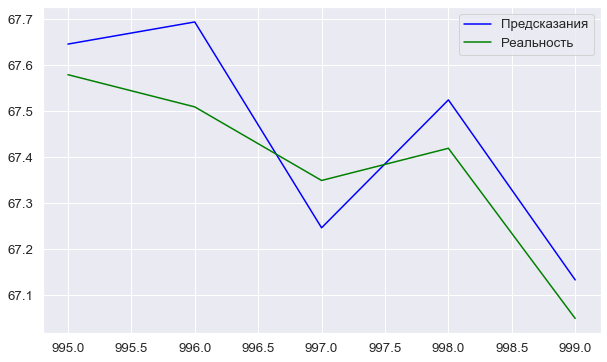

In [63]:
param_grid = {}
ILV_USDT_lr_30m = ILV_USDT_30m.copy()
prognoz(ILV_USDT_lr_30m, LinearRegression(), param_grid)

Модель повторяет тренд за тестовыми данными, но не очень точно. Такое нас не устраивает. Давайте посмотрим на другие модели

max_lag = 1
rolling_mean_size = 1
0.8914969602565239
MAE: 0.12799999999999728

DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, random_state=42)
max_lag = 1
rolling_mean_size = 3
0.873460688486694
MAE: 0.10524999999999807

DecisionTreeRegressor(max_depth=10, min_samples_leaf=8, random_state=42)
max_lag = 3
rolling_mean_size = 1
0.8550920413819459
MAE: 0.11866666666666674

DecisionTreeRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)
max_lag = 3
rolling_mean_size = 3
0.8828226445095291
MAE: 0.1899999999999949

DecisionTreeRegressor(max_depth=20, min_samples_leaf=2, random_state=42)


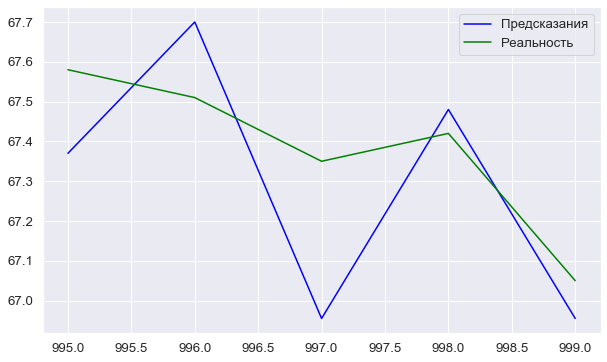

In [64]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 8, 16]
}
ILV_USDT_dt_30m = ILV_USDT_30m.copy()
prognoz(ILV_USDT_dt_30m, DecisionTreeRegressor(random_state = RANDOM_STATE), param_grid)

Еще хуже. Смотрим еще

max_lag = 1
rolling_mean_size = 1
0.8909962912654875
MAE: 0.12529181204600376

LGBMRegressor(max_depth=20, n_estimators=50, seed=42, verbosity=-1)
max_lag = 1
rolling_mean_size = 3
0.9099330909770705
MAE: 0.13199707933330843

LGBMRegressor(max_depth=20, n_estimators=50, seed=42, verbosity=-1)
max_lag = 3
rolling_mean_size = 1
0.8682868848886072
MAE: 0.13296777277055014

LGBMRegressor(max_depth=20, n_estimators=50, seed=42, verbosity=-1)
max_lag = 3
rolling_mean_size = 3
0.8681445722605527
MAE: 0.12400237701601782

LGBMRegressor(max_depth=20, n_estimators=50, seed=42, verbosity=-1)


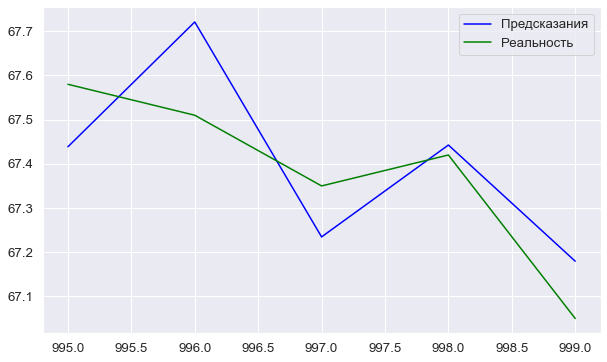

In [65]:
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [20, 50, 100]
}
ILV_USDT_lgbm_30m = ILV_USDT_30m.copy()
prognoz(ILV_USDT_lgbm_30m, LGBMRegressor(seed=RANDOM_STATE, verbosity=-1), param_grid)

Немного лучше прошлой, но все равно немного не то. С такими погрешностями будет очень сложно и нестабильно предсказывать точки входа и выхода. По крайней мере это оказалось намного ближе, чем если бы мы брали свечи с интервалом в 1 минуту и задержкой в 30.

**Самое время добавить еще две модели и посмотреть, что ни могут. Это SVR и KNN.** Конечно от KNN не стоит ожидать хороших результатов, так как она не совсем подходит для решения таких задач, но в линейную регрессию я тоже не особо верил, а она пока что дает лучшие результаты. SVR хороша тем, что может с помощью перебора своих ядер находить различные зависимости. Если и вправду линейная регрессия настолько хороша, то и модель SVR должна проявить себя с ядром linear. Давайте смотреть

max_lag = 1
rolling_mean_size = 1
1.4988793210817677
MAE: 0.6268

KNeighborsRegressor()
max_lag = 1
rolling_mean_size = 3
1.6894370338114548
MAE: 0.4572000000000003

KNeighborsRegressor()
max_lag = 3
rolling_mean_size = 1
1.696683947667681
MAE: 0.31119999999999665

KNeighborsRegressor()
max_lag = 3
rolling_mean_size = 3
1.7435476254339126
MAE: 0.3736000000000018

KNeighborsRegressor()


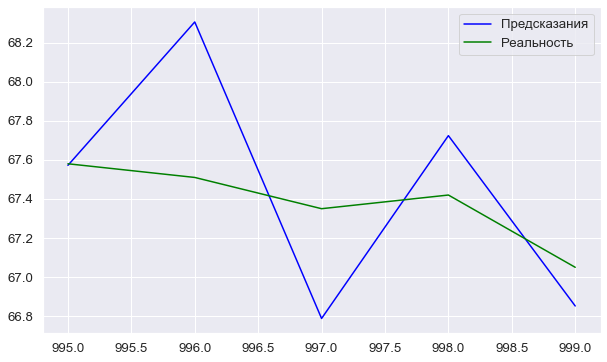

In [66]:
param_grid = {}
ILV_USDT_knn_30m = ILV_USDT_30m.copy()
prognoz(ILV_USDT_knn_30m, KNeighborsRegressor(), param_grid)

Все очень плохо у модели ближайших соседей, как и предполагалось

max_lag = 1
rolling_mean_size = 1
0.21805511861786595
MAE: 0.11543207721989006

SVR(kernel='linear')
max_lag = 1
rolling_mean_size = 3
0.22063890821430077
MAE: 0.13825193682986595

SVR(kernel='linear')
max_lag = 3
rolling_mean_size = 1
0.2173694128495878
MAE: 0.117524117558321

SVR(kernel='linear')
max_lag = 3
rolling_mean_size = 3
0.221564907545357
MAE: 0.1180456565264933

SVR(kernel='linear')


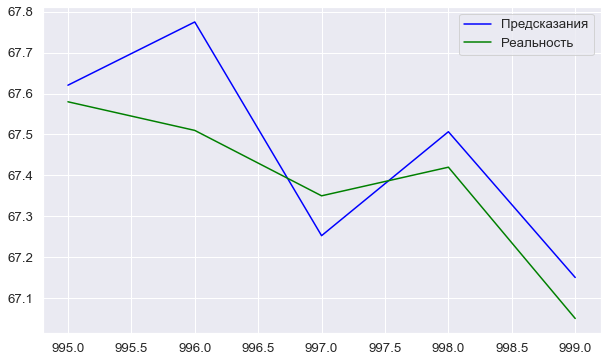

In [67]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
ILV_USDT_svr_30m = ILV_USDT_30m.copy()
prognoz(ILV_USDT_svr_30m, SVR(), param_grid)

**Лучшим ядром оказалось linear. Это означает, что и с интервалом свечей в 1 минуту и в 30, линейная модель справляется лучше всех других моделей.** График очень похож на предсказания линейной модели, но по метрикам SVR показала результат чуть-чуть лучше, однако время, которое тратится на обучение, намного больше у SVR. Линейная регрессия дает свои предсказания моментально.

## Создание правил для входа и выхода

На данном этапе нам нужно придумать, когда стоит покупать акции, а когда - продавать. У нас уже есть модель, которая может предсказывать цену на каждую следующую минуту торговли. И есть еще одна - она предсказывает примерную цену на ближайшие 30 минут. Мы попробуем что-то придумать с обеими моделями. Начнем со второй.

### Правило 1

У нас есть простенькая модель линейной регрессии, которая каждые 30 минут может предсказывать приблизительную цену на следующие полчаса. Для нашего правила она будет больше помогать понять: куда пойдет график?  
Суть будет в следующем: если у нас по предсказанию за 30 минут цена поднимется, то мы мы взодим, если через 30 минут мы получим такое же предсказание, то мы не держим, а если иное, то уже продаем, так как пройдет минимум час, а нам нужно делать предсказания на 2 часа.

Для реализации мы напишем функцию rule_1, которая будет принимать на вход датасет, а на выходе мы получим график, на котором будут показаны точки входа (зеленые) и выхода (красные), их кол-во, выручка в цене и в процентах и выручка с учетом комиссии.

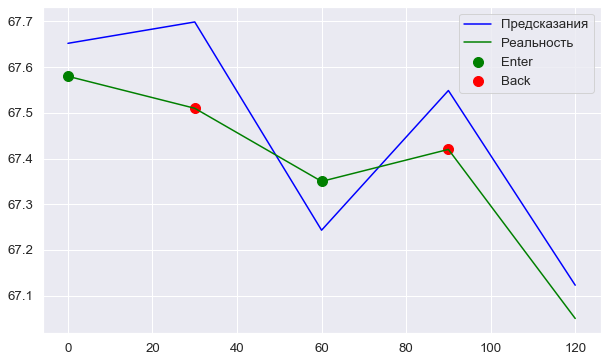

Выручка:  1.4210854715202004e-14
Выручка в процентах:  2.1089986517470544e-14 %
Кол-во сделок:  2
Чистая прибыль:  -0.2698599999999942
Чистая прибыль в процентах:  -0.4004927131874895 %


In [68]:
rule_1(ILV_USDT_30m)

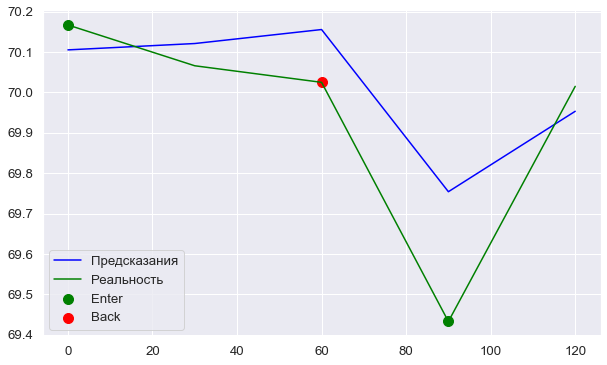

Выручка:  0.4399999999999977
Выручка в процентах:  0.6290998724642952 %
Кол-во сделок:  2
Чистая прибыль:  0.16035999999999717
Чистая прибыль в процентах:  0.22927830806448438 %


In [69]:
rule_1(TRB_USDT_30m)

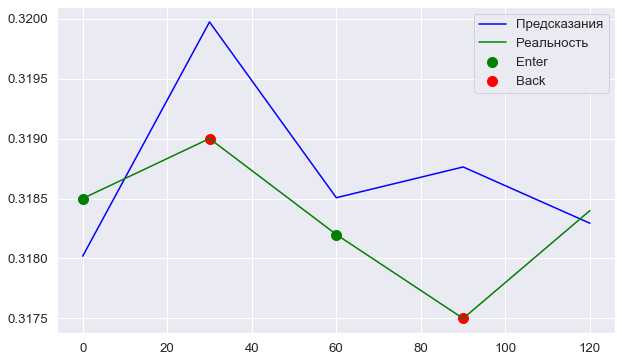

Выручка:  -0.00019999999999997797
Выручка в процентах:  -0.06282985674791969 %
Кол-во сделок:  2
Чистая прибыль:  -0.0014732000000000078
Чистая прибыль в процентах:  -0.46280472480522983 %


In [70]:
rule_1(MANA_USDT_30m)

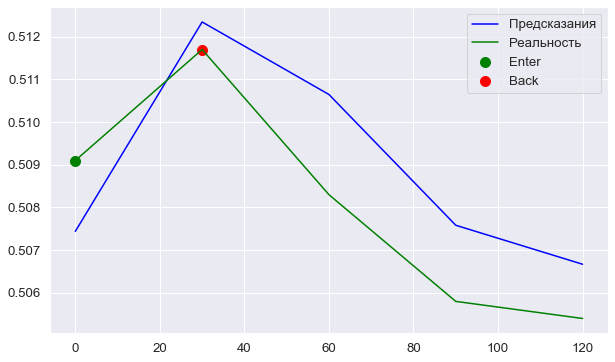

Выручка:  0.0026000000000000467
Выручка в процентах:  0.5117505806400912 %
Кол-во сделок:  1
Чистая прибыль:  0.0015792000000000028
Чистая прибыль в процентах:  0.3108294295949303 %


In [71]:
rule_1(HOOK_USDT_30m)

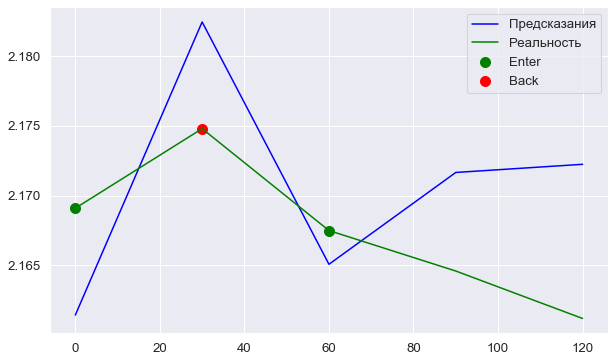

Выручка:  -0.0005999999999999339
Выручка в процентах:  -0.027682427195213428 %
Кол-во сделок:  2
Чистая прибыль:  -0.00927260000000052
Чистая прибыль в процентах:  -0.42781345735063114 %


In [72]:
rule_1(WLD_USDT_30m)

Получилось достаточно интересное правило, но не очень эффективное. Это из-за того что пределенное время входа или выхода нельзя выбрать, так как модель делает предсказания только на 30 минут. Она может показать общий рост графика, а точки входа и выхода мы можем взять не самую оптимальную.  
Конечно, можно поэкспериментировать, взять другие интервалы, как в 20, 10 минут, но я считаю, что достаточно было показать концепцию решения.\, а подбор лучшего результата просто загромоздит тертадку, которая уже и так огромная. Лучше перейдем ко второму правилу.

## Правило 2

Для его реализации нам потребуется вернуть старые датафреймы с 5 монетами. Хорошо, что они у нас записаны в переменных: ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT. Создадим правило с помощью цикла, который каждый раз будет обучать модель на одно значение меньше в тестовой выборке. Это нам поможет делать предсказания на 1 минуту вперед, как в реальном времени. С помощью счетчиков и условий мы создаем правило, которое вкратце делает +1 к счетчику, если у нас цена возрастет в следующую минуту, иначе -1. При счетчике > определенного числа мы делаем вход, а при < числа - выход. Конечно, есть еще разные условия и ограничения. Например, при росте цены 2 раза подряд мы счетчик увеличиваем не на 2, а на 4. Тоже самое и с падением цены

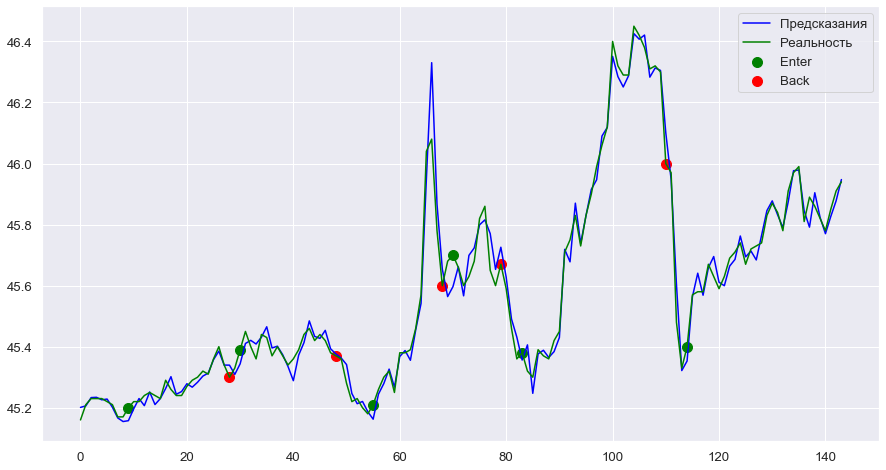

Выручка:  1.5999908447265625
Выручка в процентах:  3.510767569629946 %
Кол-во сделок:  6
Чистая прибыль:  1.053830848693849
Чистая прибыль в процентах:  2.3123602110999917 %


In [73]:
rule_2(ILV_USDT)

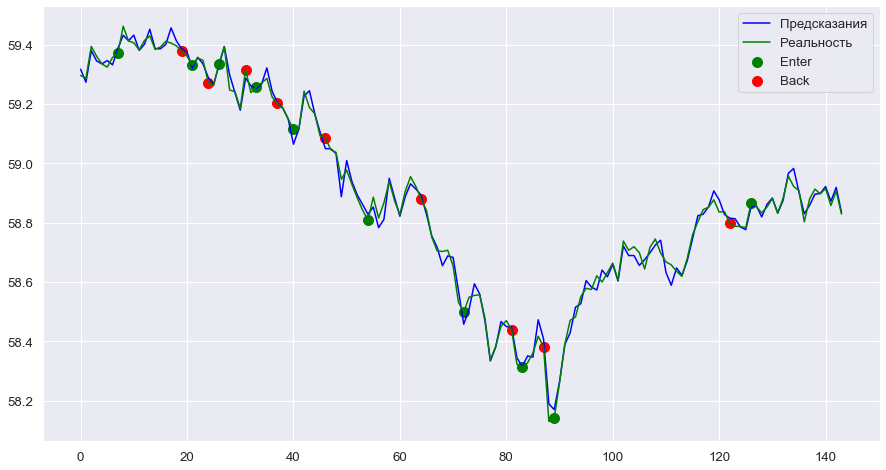

Выручка:  0.5450019836425781
Выручка в процентах:  0.9253104323341276 %
Кол-во сделок:  10
Чистая прибыль:  -0.6336150093078672
Чистая прибыль в процентах:  -1.0757586133494783 %


In [74]:
rule_2(TRB_USDT)

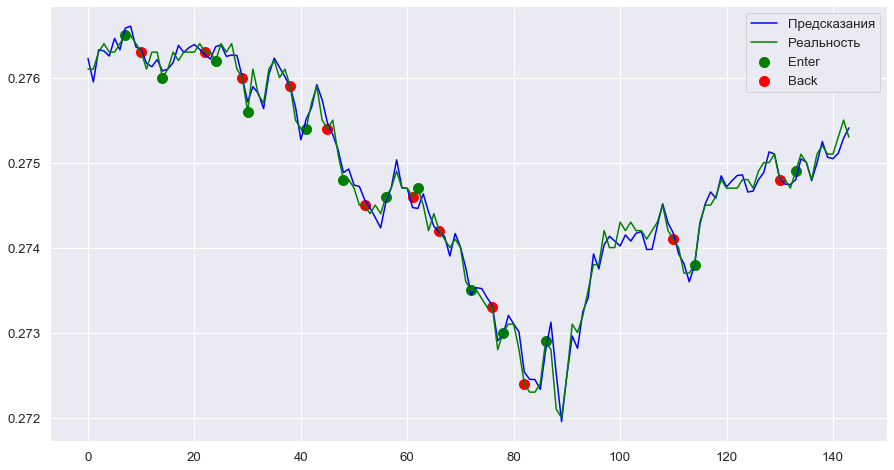

Выручка:  0.0012001097202301025
Выручка в процентах:  0.43676311341415586 %
Кол-во сделок:  13
Чистая прибыль:  -0.005944890230894118
Чистая прибыль в процентах:  -2.1635594832553093 %


In [75]:
rule_2(MANA_USDT)

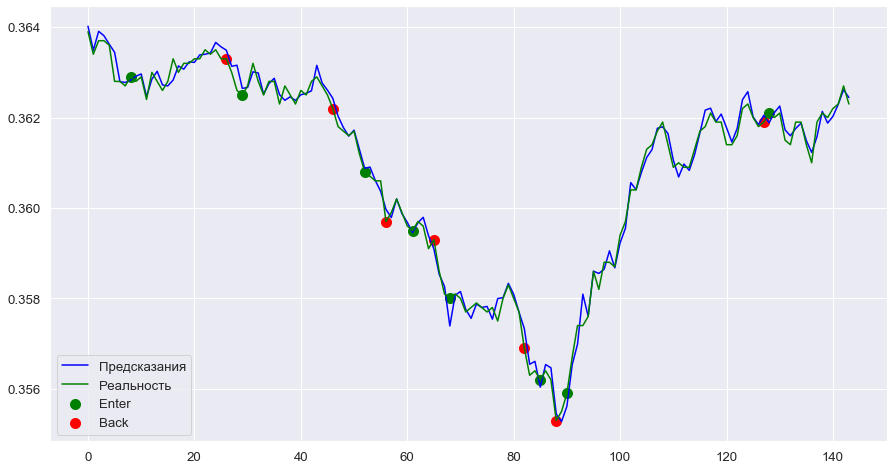

Выручка:  0.0029999911785125732
Выручка в процентах:  0.8312815407595672 %
Кол-во сделок:  8
Чистая прибыль:  -0.0027588088214396955
Чистая прибыль в процентах:  -0.7644511971146998 %


In [76]:
rule_2(HOOK_USDT)

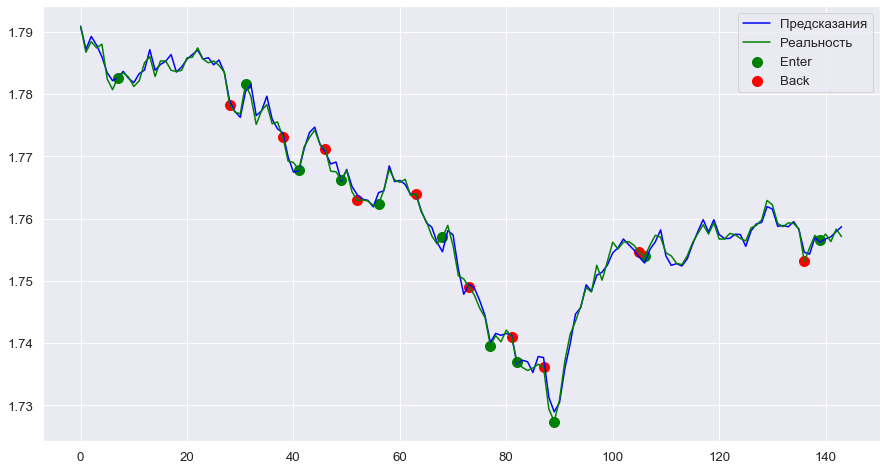

Выручка:  0.008400321006774902
Выручка в процентах:  0.47656962747009485 %
Кол-во сделок:  11
Чистая прибыль:  -0.03027187907695783
Чистая прибыль в процентах:  -1.7173936713716509 %


In [77]:
rule_2(WLD_USDT)

Выручка без комиссии и показатели в процентах получились очень даже неплохими. Мы ни разу не ушли в минус. Но есть одна проблемка это кол-во сделок. Мы их делаем очень много, а если учитывать комиссию брокера, то короткие и постоянные сделки, которые приносят очень - мало нам не выгодно, так как эти деньги мы теряем на процентах брокера. Это можно заметить на последних 4 графиках. При тренде падения цены мы все равно совершаем сделки, которые нам не выгодны. А при тренде роста мы уходим в плюс.

**И тут я подумал, что первое правило у нас предсказывает рост или падение на 30 мин, что достаточно много. Можно сказать делает предсказание небольшого тренда. А второе правило совершает плюсовые сделки, но делает это слишком много, из-за чего получаются короткие сделки. Хоть они и уходят в плюс, но при учете комиссии они часто уходят в минус. И при медленном тренде падения цены мы делаем плохие сделки. Вот я и подумал совместить два правила. Первое поможет для второго определять тренд на ближайшие 30 минут, чтобы определиться делать ли в этом промежутке входы и выходы. Это поможет сделать ограничения по кол-ву сделок у второго правила, которое в свою очередь будет совершать покупки только при дальнейшем росте графика.**

## Общее правило

Его суть уже была изложена чуть выше, но тут я расскажу принцип его работы. Все так же с помощью цикла будем проходить все 144 минуты тестовой выборки, уменьшая ее, чтобы предсказания получались как в реальном времени, не зная будущее. Каждые полчаса с помощью правила 1 будем делать предсказание роста или падения цены монеты на 30 мин. При росте мы заходим в часть кода, где прописано правило входа/выхода и делаем сделки. Если цена падает на ближайшие 30 мин, то мы просто ничего не делаем. Это должно привести нас к положительным сделкам и сократить их кол-во, чего как раз не хватало в правиле 2.  
При создании функции rule_1(data, data_1) возникла небольшая проблема в синхронизации данных. Время считывания у датасетов для интервала свечей в 1 и 30 минут было одинаковое, но размеры обучающих выборок разные, из-за чего время на тестовых выборках уже не совпадало и нельзя бы было объединять наши два способа, так как они предсказывали другое. Для решения этой проблемы я заново считал данные, подстроившись под 30 минутный интервал.

In [78]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
    'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

symbols = ['ILVUSDT', 'TRBUSDT', 'MANAUSDT', 'HOOKUSDT', 'WLDUSDT', 'BTCUSDT']

dfs = []

for symbol in symbols:
    params = {
        'symbol': symbol,
        'interval': '1m',  
        'limit': 1440,
        'startTime':  1721808660000
    } 
    url = 'https://fapi.binance.com/fapi/v1/klines'
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data, columns=columns)
        dfs.append(df)  
    else:
        print(f'Ошибка {response.status_code}: {response.text}')

ILV_USDT = dfs[0]
TRB_USDT = dfs[1]
MANA_USDT = dfs[2]
HOOK_USDT = dfs[3]
WLD_USDT = dfs[4]
BTC_USDT = dfs[5]

ILV_USDT = ILV_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
TRB_USDT = TRB_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
BTC_USDT = BTC_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
MANA_USDT = MANA_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
HOOK_USDT = HOOK_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)
WLD_USDT = WLD_USDT.drop(['close', 'close_time', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis = 1)

coins = [ILV_USDT, TRB_USDT, MANA_USDT, HOOK_USDT, WLD_USDT, BTC_USDT]
columns = ['open_time', 'open', 'high', 'low','volume', 'number_of_trades']
for coin in coins:
    for column in columns:
        coin[column] = pd.to_numeric(coin[column], errors='coerce')

ILV_USDT['btc'] = BTC_USDT['open']
TRB_USDT['btc'] = BTC_USDT['open']
MANA_USDT['btc'] = BTC_USDT['open']
HOOK_USDT['btc'] = BTC_USDT['open']
WLD_USDT['btc'] = BTC_USDT['open']

const = ILV_USDT.loc[0, 'open_time']
ILV_USDT['open_time'] = (ILV_USDT['open_time'] - const) / (1000 * 60) #  перевод из мс в мин
ILV_USDT['open_time'] = ILV_USDT['open_time'].astype('int')

const = TRB_USDT.loc[0, 'open_time']
TRB_USDT['open_time'] = (TRB_USDT['open_time'] - const) / (1000 * 60) #  перевод из мс в мин
TRB_USDT['open_time'] = TRB_USDT['open_time'].astype('int')

const = MANA_USDT.loc[0, 'open_time']
MANA_USDT['open_time'] = (MANA_USDT['open_time'] - const) / (1000 * 60) #  перевод из мс в мин
MANA_USDT['open_time'] = MANA_USDT['open_time'].astype('int')

const = HOOK_USDT.loc[0, 'open_time']
HOOK_USDT['open_time'] = (HOOK_USDT['open_time'] - const) / (1000 * 60) #  перевод из мс в мин
HOOK_USDT['open_time'] = HOOK_USDT['open_time'].astype('int')

const = WLD_USDT.loc[0, 'open_time']
WLD_USDT['open_time'] = (WLD_USDT['open_time'] - const) / (1000 * 60) #  перевод из мс в мин
WLD_USDT['open_time'] = WLD_USDT['open_time'].astype('int')

In [79]:
print('Таблица ILV_USDT:')
display(ILV_USDT.head())
print(ILV_USDT.shape)

Таблица ILV_USDT:


,open_time,open,high,low,volume,number_of_trades,btc
0,0,70.94,71.00,70.84,160.1,107,66268.0
1,1,70.90,70.92,70.86,38.9,44,66305.9
2,2,70.93,71.00,70.89,99.8,76,66256.8
3,3,70.95,71.01,70.95,59.9,57,66223.5
4,4,70.99,71.07,70.98,33.5,88,66200.0


(1440, 7)


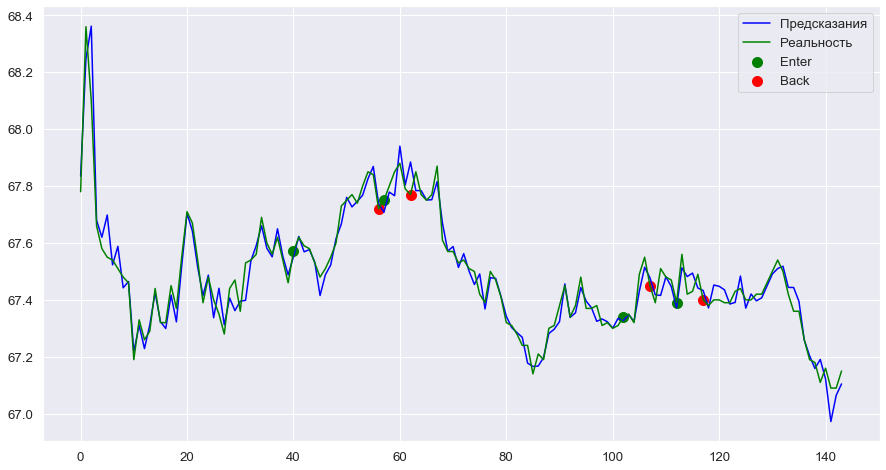

Выручка:  0.29000000000000625
Выручка в процентах:  0.4297339683297684 %
Кол-во сделок:  4
Чистая прибыль:  -0.2503899999999959
Чистая прибыль в процентах:  -0.37103823562098837 %


In [80]:
rule(ILV_USDT_30m, ILV_USDT)

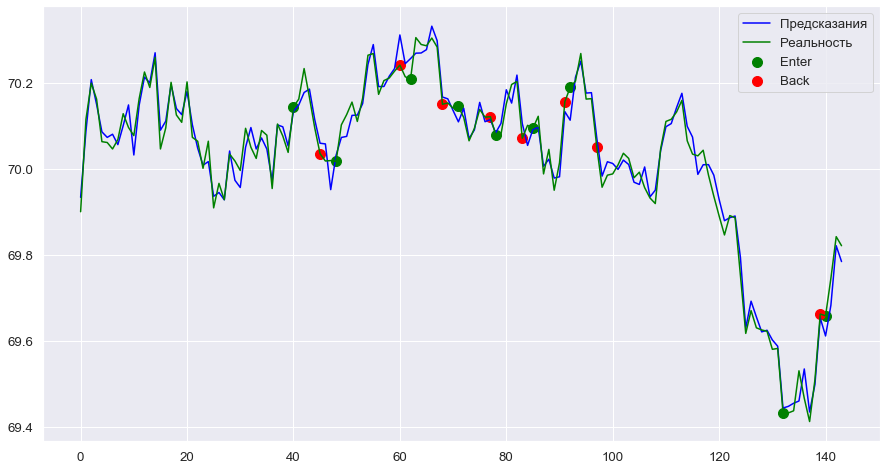

Выручка:  0.3410000000000082
Выручка в процентах:  0.4869613094642016 %
Кол-во сделок:  9
Чистая прибыль:  -0.9192929999999819
Чистая прибыль в процентах:  -1.3127862846371106 %


In [81]:
rule(TRB_USDT_30m, TRB_USDT)

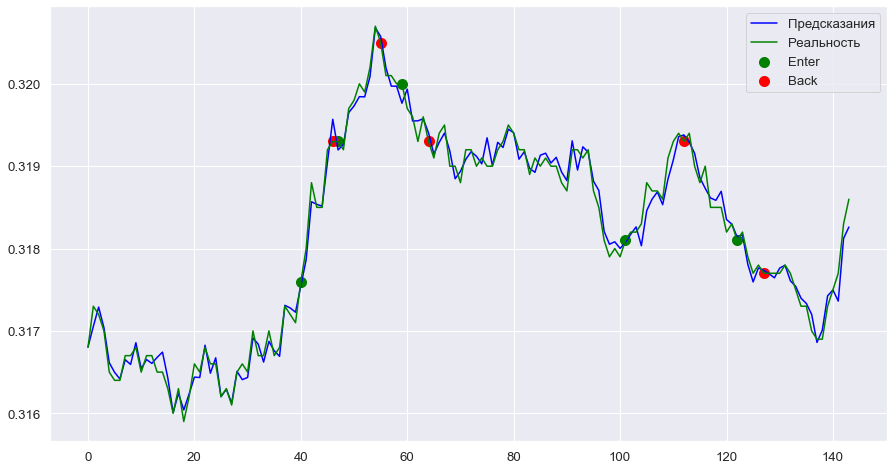

Выручка:  0.002999999999999947
Выручка в процентах:  0.9429061590106305 %
Кол-во сделок:  5
Чистая прибыль:  -0.000189200000000056
Чистая прибыль в процентах:  -0.05946594842828907 %


In [82]:
rule(MANA_USDT_30m, MANA_USDT)

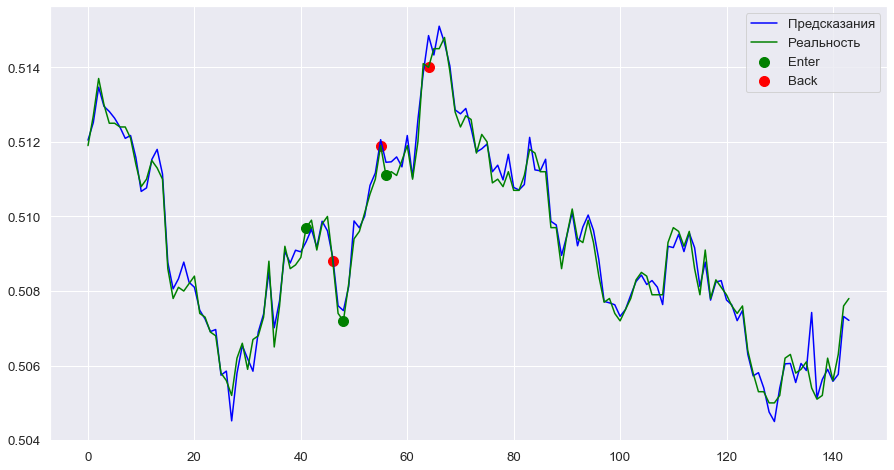

Выручка:  0.006700000000000039
Выручка в процентах:  1.3158289531467864 %
Кол-во сделок:  3
Чистая прибыль:  0.0036373000000000655
Чистая прибыль в процентах:  0.7143380076538604 %


In [83]:
rule(HOOK_USDT_30m, HOOK_USDT)

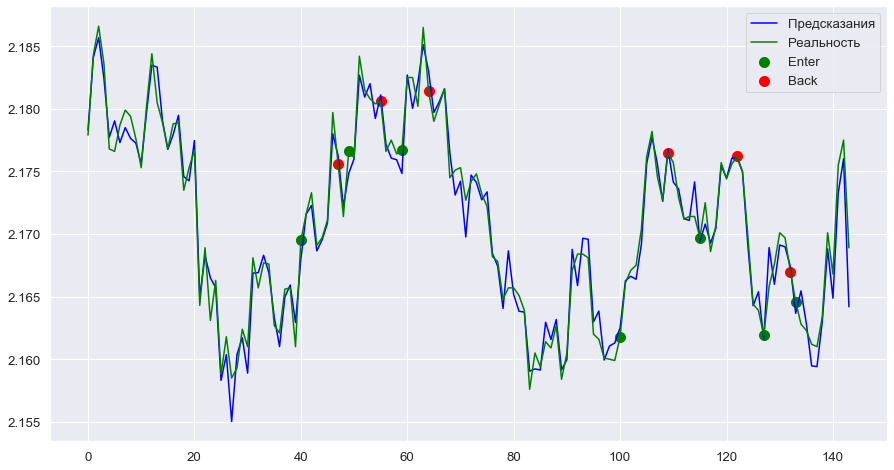

Выручка:  0.04539999999999944
Выручка в процентах:  2.0912262923340634 %
Кол-во сделок:  7
Чистая прибыль:  0.014992999999999146
Чистая прибыль в процентах:  0.6906113612546964 %


In [84]:
rule(WLD_USDT_30m, WLD_USDT)

Вот такие значения и графики у нас получились в итоговом правиле. Оно показало лучший результат из 3. Конечно тут есть некоторые недочеты и что-то можно исправить и улучшить, но у меня получилось так. Как мне кажется главное было показать структуру и логику решения, а не улучшить результат еще на 0.01%

Проект получился очень объемным, интересным, полезным и очень позновательным. Мы постарались проанализировать рынок криптовалюты, создали две модели, которые предсказывают рост или падение цены монеты и разработали три правила, которые помогают в реальном времени принять решение о входе или выходе. Но для этого мы прошли через несколько важных этапов без которых у нас бы ничего не получилось:  
* **Загрузка и подготовка данных.** Выполнили 5 запросов к API биржи Binance по указанному URL, содержащий параметры для запроса данных о свечах (candlestick) с биржи Binance, включая символ валютной пары, интервал времени, лимит свечей и начальное время. Взяли 5 первых попавшихся монет, которые были не слишком популярны. Вывели краткую информацию и поверхностно изучили данные. Поменяли типы многих столбцов с object на float. С помощью функции analiz внимательнее осмотрели наши данные. Пропусков и дубликатов не было замечено, что хорошо. Оптимизировали датафреймы для быстрой работы с ними. В этом нам помогла функция optimize_memory_usage. Затем мы удалили признаки, которые не приносили особой пользы. Это были: close_time, close, quote_asset_volume, taker_buy_base_asset_volume и taker_buy_quote_asset_volume. После этого у нас осталось 6 признаков, считая целевой.
* **Исследовательский анализ.** В исследовательском анализе мы постарались посмотреть на наши +- подготовленные данные с помощью визуализации и таких библиотек, как seborn, matplotlib мы посмотрели на то, как распределены наши признаки, построили диаграммы временных рядов. По гистограммам и ящикам с усами можно сказать, что признаки у монет ведут себя достаточно схоже. Первые (open, high, low), не считая время, имеют несколько бугров. Это показывает непредсказуемое поведение рынка. У последних двух признаков во всех монетах распределения похожи на Пуассона. На графиках со смещениями признака времени общих трендов и сезонностей на таком маленьком отрезке не было замечено. Если только для каждого графика были отдельные тренды, но и они не сказать, что явные.
* **Проверка гипотез.** Мы проверили гипотезы, которые оказались верными. Первая гипотеза была про то что цена биткоина влияет на стоймость монеты ILV_USDT и других не таких дорогих и популярных криптовалют. Благодаря этому мы добавили новый признак в наши таблицы, а именно - цена биткоина. Еще одной гипотезой мы проверили, как много сможем потерять денег, если наша модель сильно ошибется или что-то пойдет не так.
* **Корреляционный анализ.** Посмотрели на зависимость признаков, из которых мы создадим другие с помощью задержки shift и скользящего среднего, поэтому нам нужно подобрать хоршие и нужные признаки, чтобы модель получилась хорошей. Была заметна очень сильная корреляция у open с high, low. Возможно стоило взять свечи с большим интервалом (5 минут), но тогда у нас бы модель уже обучалась больше на долгосрочную перспективу, чем на точный анализ двух часов. Возможно стоит проверить и эту так сказать гипотезу. Новый признак btc оправдал свои ожиданияю Плохо себя проявил признак change. У него слишком слабая корреляция со всеми, поэтому его пришлось удалить.
* **Создание моделей.** Долгожданный этап, на котором мы проверили очень много моделей регрессии (линейная, метод опорных векторов, дерево решений, градиентный бустинг, ближайшие соседи). Странно, но лучшей моделью оказалась линейная регрессия и SVR с линейным ядром. Они показали лучшие результаты метрк RMSE, MAE, что подтвердили графики сравнения тестовой выборки и предсказания модели. Остальные модели показали себя плохо скорее всего из-за того, что в тестовой выборке попались выбросы, которых не было в тренировочной. Это было заметно на графиках, где линия предсказаний в один момент просто становилась горизонтальной и не могла повыситься, в то время как тестовые данные были выше. В итоге мы выбрали линейную модель, так как она хоть и давала результаты чуть-чуть хуже, однако она работала намного быстрее опорных векторов, что для нас очень важно, так как мы должны делать предсказания каждую минуту. Нашу модель мы использовали в двух случаях, чтобы предсказвать будущую цену с интервалами свечей в 1 и 30 минут.
* **Создание правил входа и выхода.** У нас получилось целых 3 правила, которые показали себя не слишком хорошо по выручке покупок и продаж с учетом комиссии брокера. Были небольшие отрицательные значения и положительные тоже. Основная проблема первого правила заключалась в гибкости, которой у нее не было из-за интервала предсказания в 30 минут. У второго наоборот - частые предсказания свечей в 1 минуту провоцировали алгоритм на покупку монет, так как она просто не могла узнать далекое будущее этой валюты. В итоге появилась идея создать общее правило, которое учитывало оба прошлых и могла делать более менее осознанные и правильные выборы.

Лучшим правилом из всех придуманных оказалось совместное. Конечно, результаты выручек оказались не настолько хорошими, чтобы можно было на этом заработать, но это результат одного человека и нескольких дней работы над созданием модели и правил. Данный алгоритм можно где-то доработать, сделать его немного лучше, но на это нужно больше времени.